# LendingClub_Risk_Evaluation

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
import pandas as pd
import numpy as np
from scipy import sparse
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.cross_validation import train_test_split,StratifiedKFold,KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
import time
import random
import datetime
from datetime import datetime
from sklearn import preprocessing, pipeline, metrics, grid_search, cross_validation
from math import sqrt,log
import seaborn as sns
import matplotlib.cm as cm

import xgboost as xgb
sns.set_style("whitegrid")
sns.set_context("poster")

import matplotlib.pyplot as plt
%matplotlib inline

import sys
import operator


from hyperopt import hp
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials 

from sklearn.metrics import roc_auc_score, roc_curve, auc

from sklearn.linear_model import LogisticRegression

In [2]:
Loan_data = pd.read_csv('LoanStats3c.csv',header =1,
                        dtype={ 'id': np.str,'member_id': np.str},
                        parse_dates=['issue_d','earliest_cr_line','last_pymnt_d','next_pymnt_d','last_credit_pull_d'],
                        nrows=235629
                       )

# 用 skeprows=1 也可以 

C:\Users\sge\AppData\Local\Continuum\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2723: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
Loan_data.loan_status.value_counts()
# why mine is different with the notebook shown in class

Current               123964
Fully Paid             80740
Charged Off            23772
Late (31-120 days)      3998
In Grace Period         2094
Late (16-30 days)       1048
Default                   13
Name: loan_status, dtype: int64

# Focus on closed loan:
## charge off :1
## Fullt paid: 0

In [4]:
Used_data = Loan_data.query("loan_status == 'Fully Paid' or loan_status == 'Charged Off'")

In [5]:
Used_data.shape

(104512, 111)

In [6]:
Used_data["loan_status"] =  Used_data["loan_status"].map({"Charged Off":1, "Fully Paid":0})

C:\Users\sge\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [7]:
Used_data["loan_status"].unique(),Used_data["loan_status"].describe()

(array([0, 1], dtype=int64), count    104512.000000
 mean          0.227457
 std           0.419192
 min           0.000000
 25%           0.000000
 50%           0.000000
 75%           0.000000
 max           1.000000
 Name: loan_status, dtype: float64)

## Out of Time testing and In-time cross-validation

In [8]:
Used_data['issue_d'].head()
# As I read with timstampe I dont need to deal with the time

1   2014-12-01
2   2014-12-01
4   2014-12-01
5   2014-12-01
6   2014-12-01
Name: issue_d, dtype: datetime64[ns]

In [9]:
Used_data['issue_d'].describe() #orginal coloum only have month

count                  104512
unique                     12
top       2014-10-01 00:00:00
freq                    14839
first     2014-01-01 00:00:00
last      2014-12-01 00:00:00
Name: issue_d, dtype: object

In [10]:
test_data = Used_data.query("issue_d >= '2014-10-01'")

In [11]:
test_data['issue_d'].describe()

count                   26720
unique                      3
top       2014-10-01 00:00:00
freq                    14839
first     2014-10-01 00:00:00
last      2014-12-01 00:00:00
Name: issue_d, dtype: object

In [12]:
train_data = Used_data.query("issue_d <'2014-10-01'")

In [13]:
train_data['issue_d'].describe()

count                   77792
unique                      9
top       2014-07-01 00:00:00
freq                    12979
first     2014-01-01 00:00:00
last      2014-09-01 00:00:00
Name: issue_d, dtype: object

In [14]:
train_data['train_flg']=1
test_data['train_flg']=0
print train_data['train_flg'].describe()
test_data['train_flg'].describe()

count    77792.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
Name: train_flg, dtype: float64


C:\Users\sge\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\sge\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


count    26720.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: train_flg, dtype: float64

In [15]:
df_all =  pd.concat((train_data,test_data),axis =0,ignore_index= True)

In [16]:
df_all.shape

(104512, 112)

## Drop features

### meanless or can not extract information

In [17]:
df_all.drop(['member_id'], axis =1 ,inplace= True)

In [18]:
df_all.drop(['pymnt_plan','desc','title'], axis =1 ,inplace= True)

### info leak

In [19]:
df_all.drop(['out_prncp','out_prncp_inv', 'total_pymnt', 'total_pymnt_inv','total_rec_prncp'], axis =1 ,inplace= True)

In [20]:
df_all.last_pymnt_d.head() ## the time passed issued day

0   2015-07-01
1   2015-02-01
2   2015-07-01
3   2015-11-01
4   2015-05-01
Name: last_pymnt_d, dtype: datetime64[ns]

In [21]:
df_all.drop(['last_pymnt_d','last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d'], axis =1 ,inplace= True)

In [22]:
df_all.drop(['total_rec_late_fee', 'recoveries', 'collection_recovery_fee'], axis =1 ,inplace= True)

In [23]:
df_all.shape

(104512, 96)

## Data cleaning

In [24]:
df_all.replace('n/a',np.nan,inplace=True)
df_all['int_rate']=df_all.int_rate.apply(lambda x : x.split('%')[0]).astype(np.float)/100
df_all['emp_length'].fillna(value= 0, inplace =True)
df_all['emp_length'].replace(to_replace = '[^0-9]+',value ='',inplace=True, regex=True)#here  regex=True means regular express
df_all['emp_length']=df_all['emp_length'].astype(int)

In [25]:
df_all.earliest_cr_line = (df_all.issue_d-df_all.earliest_cr_line).astype('timedelta64[D]')/365

# Here I dont use delta time to today time, I use the issue_d

In [26]:
df_all['revol_util'] = pd.Series(df_all['revol_util']).str.replace('%','').astype(float)/100

In [27]:
df_all['term']=df_all['term'].apply(lambda x : x.split(' months')[0]).astype(np.int16)

# Frequency encoding:
###  zipcode

In [29]:
df_all.zip_code =  df_all.zip_code.apply(lambda x: x[0:3])
zip_code_freq =  df_all.groupby("zip_code").size().reset_index()
zip_code_freq.columns = ['zip_code' , 'zip_code_freq']
df_all = df_all.merge(zip_code_freq, how = "left" , on = "zip_code")

###  emp_title

In [30]:
emp_title_freq =  df_all.groupby("emp_title").size().reset_index()
emp_title_freq.columns = ['emp_title' , 'emp_title_freq']
df_all = df_all.merge(emp_title_freq, how = "left" , on = "emp_title")

## EDA

barplot is very handy to show the feature relation with target.

In [31]:
def countinuous_variable_plot(feature_name,colortype="Set1",bins=20,limit=0,downlimit=-1):
    fig, (ax1,ax2)= plt.subplots(2,1,figsize=(16,10))
    try:
        sns.set_style("whitegrid",{'axes.edgecolor':'0'})
        factor = pd.qcut(df_all[feature_name], 5 ,labels =False) # make 5 groups
        table = df_all.groupby([factor, 'loan_status']).size() # 2 groupby, first for factor, second for loan_status.
        table =  table.unstack('loan_status')
        normedtable = table.div(table.sum(1),axis=0) # devide the count by total 
        normedtable.ix[:,1].plot(kind = 'bar' ,alpha =0.9,color ="#4AA4FE", ax =ax1)
        ax1.set_xlabel("%s precentile" % feature_name,fontsize =20)
        ax1.set_ylabel("Default Rate"  ,fontsize =20)
        x = range(5)
        labels = ["20%tile","40%tile","60%tile","80%tile","100%tile"]
    #     plt.xticks(x,labels,rotation = '0',fontsize =18)
        ax1.set_xticklabels(labels,rotation = '0')
        sns.despine() 
        ax1.set_title ("Loan Performance with respect to %s" % feature_name)
    except ValueError:
        print "data is too inbalanced"
    
    if df_all[feature_name].unique().shape[0]<bins:
        bins =df_all[feature_name].unique().shape[0]
    
    if (limit !=0)|(downlimit!=-1):
        Loan_data = df_all[(df_all[feature_name]<=limit)&(df_all[feature_name]>downlimit)]
    else:
        Loan_data = df_all
    colors= sns.color_palette(colortype, Loan_data.loan_status.drop_duplicates().shape[0])
    ax2.hist([Loan_data[(Loan_data.loan_status==value)&(~Loan_data[feature_name].isnull())][feature_name] for value in Loan_data.loan_status.drop_duplicates().sort_values().tolist()],
         stacked=True,bins=bins,
        label=Loan_data.loan_status.drop_duplicates().sort_values().tolist(),color = colors[:Loan_data.loan_status.drop_duplicates().shape[0]],alpha =0.9)
    ax2.set_xlabel(feature_name, fontsize =20)
    ax2.set_ylabel("Numbers"  ,fontsize =20)
    ax2.legend()
    print "================================================================================"

    

In [32]:
def plot_bar(feature_name,data,colortype="Set1"):
    Loan_data = data
    f,(ax1,ax2) = plt.subplots(2,1,figsize=(16, 10))
    ind = np.arange(len(Loan_data.groupby(feature_name).size()))
    DF =pd.DataFrame(data={'ind':ind,
                           feature_name:Loan_data.groupby(feature_name).size().index.tolist(),
                           'count':Loan_data.groupby(feature_name).size().tolist()})
    colors= sns.color_palette(colortype, Loan_data.loan_status.drop_duplicates().shape[0])
    bottoms = [0]*len(Loan_data.groupby(feature_name).size())
    
    
    for  icolor,value  in enumerate(Loan_data.loan_status.drop_duplicates().sort_values().tolist()):
        DF[value]=DF[feature_name].map(Loan_data[Loan_data.loan_status==value].groupby(feature_name).size())
    
    DF.fillna(0)
                
    for  icolor,value  in enumerate(Loan_data.loan_status.drop_duplicates().sort_values().tolist()):
        
        ax1.bar(DF['ind'],
                DF[value],color=colors[icolor],label=value,
               bottom=bottoms,alpha=0.9)
        bottoms = [x+y for x,y in zip(bottoms , DF[value].tolist())]
    ax1.set_xticks(ind + 1/2.)
    ax1.set_xticklabels( Loan_data.groupby(feature_name).size().index.tolist())
    ax1.legend()
    ax1.grid(False)
    sns.barplot(x = feature_name,y = 'loan_status' , data=df_all,order= np.sort(df_all[feature_name].unique()),ax=ax2)
    ax2.set_title ("Loan Performance with respect to %s" % feature_name,fontsize =20)

In [33]:
dummy_list = ['emp_length','verification_status','addr_state','home_ownership','grade','sub_grade',
             'purpose','initial_list_status']

In [34]:
dummy_num_col = ['term','inq_last_6mths','delinq_2yrs','pub_rec','open_acc','acc_open_past_24mths','mort_acc','num_accts_ever_120_pd',
                'num_actv_bc_tl','num_actv_rev_tl','num_bc_sats','num_bc_tl']

In [35]:
num_col =  ['funded_amnt','int_rate','installment', 'annual_inc',
                  'dti','earliest_cr_line'
                  ,'revol_bal','revol_util','total_acc',
                  'tot_coll_amt','tot_cur_bal', 'total_rev_hi_lim',
                   'avg_cur_bal','bc_open_to_buy','bc_util','mo_sin_old_il_acct',
                  'mo_sin_old_rev_tl_op','mo_sin_rcnt_rev_tl_op','mo_sin_rcnt_tl',
                    'num_il_tl','num_op_rev_tl','num_rev_accts',
                  'num_rev_tl_bal_gt_0','num_sats','pct_tl_nvr_dlq','percent_bc_gt_75',
                   'pub_rec_bankruptcies','tax_liens','tot_hi_cred_lim','total_bal_ex_mort',
                   'total_bc_limit','total_il_high_credit_limit','emp_title_freq','zip_code_freq']

In [36]:
all_num_col = dummy_num_col+num_col

In [37]:
remove_col =['out_prncp','out_prncp_inv','total_rec_late_fee']

### duplicate 
'funded_amnt','funded_amnt_inv',

### meanless 
'id','url','title'

### same value for all rows
'out_prncp', 'out_prncp_inv' ,'policy_code','application_type','annual_inc_joint','dti_joint','verification_status_joint','open_il_6m','open_il_12m','open_il_24m','mths_since_rcnt_il','total_bal_il','il_util','open_rv_12m','open_rv_24m','max_bal_bc','all_util','inq_fi','total_cu_tl','inq_last_12m'

### info leak,
'total_rec_late_fee','issue_d','out_prncp','out_prncp_inv','total_pymnt','total_pymnt_inv','total_rec_prncp','total_rec_int','total_rec_late_fee','recoveries', 'collection_recovery_fee','last_pymnt_d','last_pymnt_amnt', 'next_pymnt_d','last_credit_pull_d','collections_12_mths_ex_med','mths_since_last_major_derog','acc_now_delinq','open_acc_6m','chargeoff_within_12_mths','delinq_amnt','mths_since_recent_bc', 'mths_since_recent_bc_dlq','mths_since_recent_inq', 'mths_since_recent_revol_delinq','num_tl_120dpd_2m','num_tl_30dpd', 'num_tl_90g_dpd_24m','num_tl_op_past_12m'

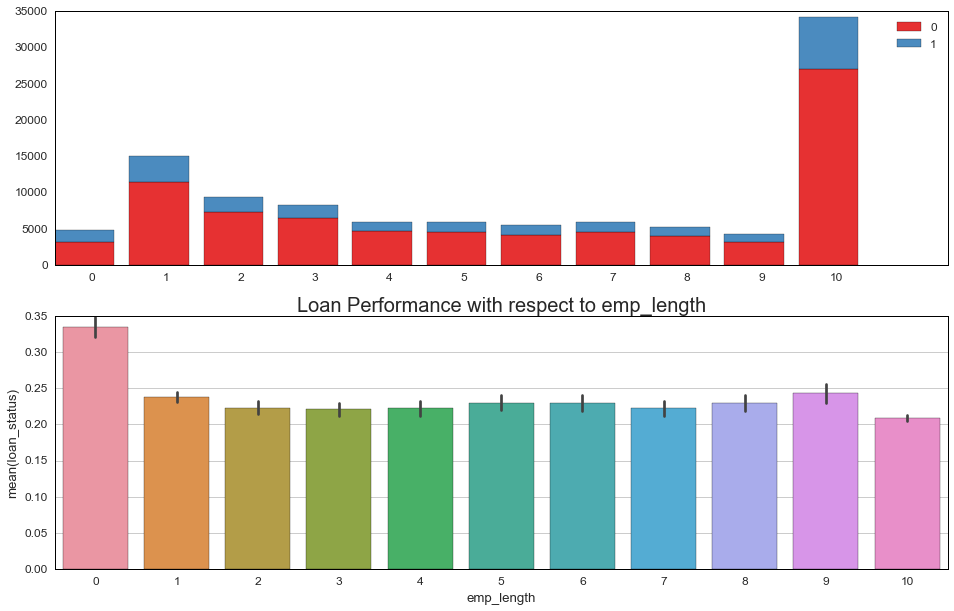

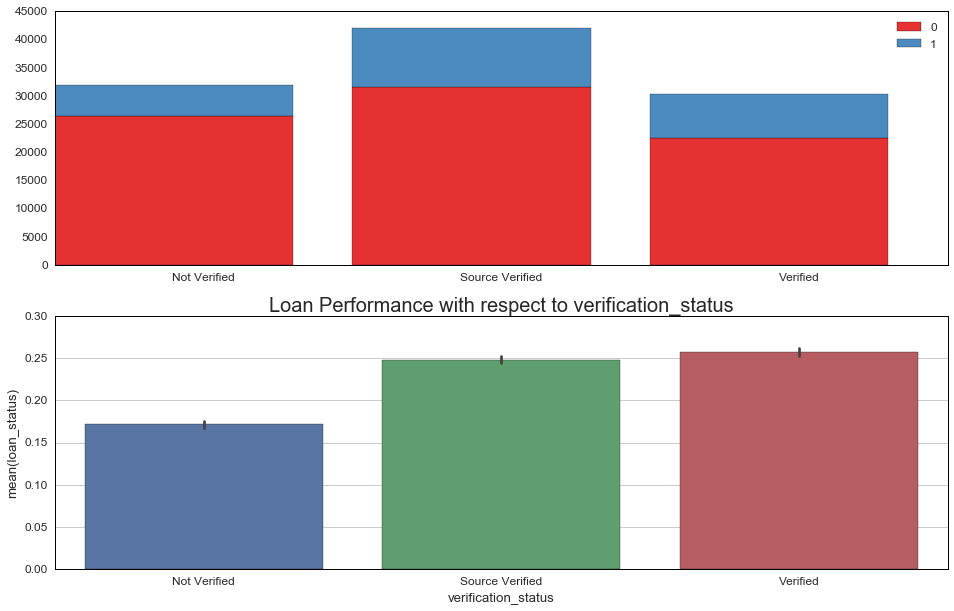

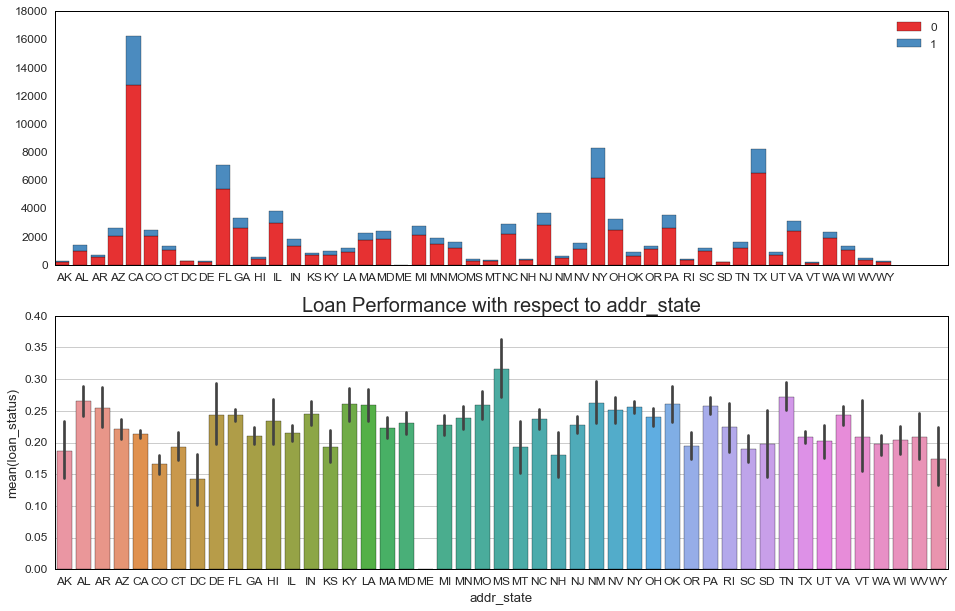

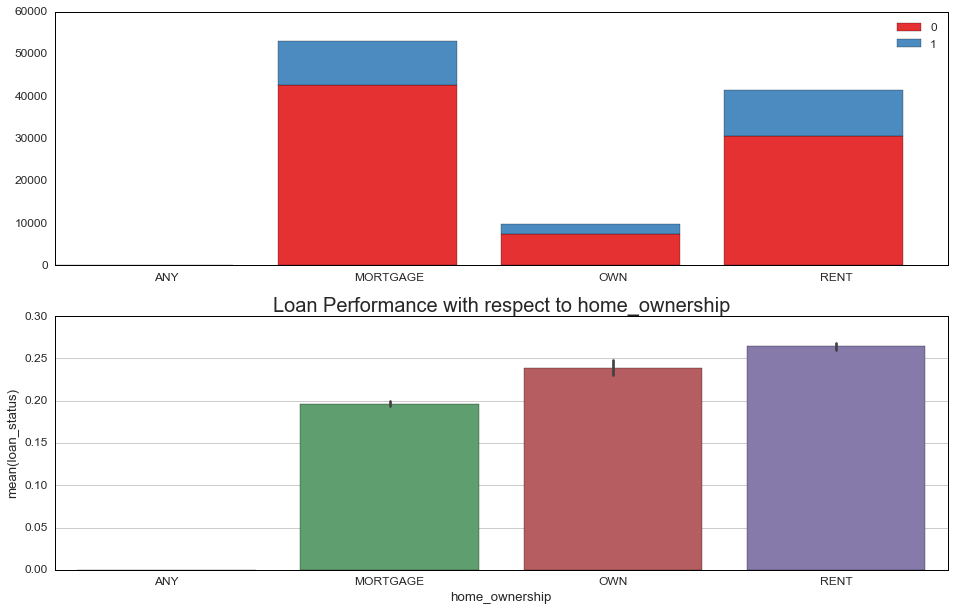

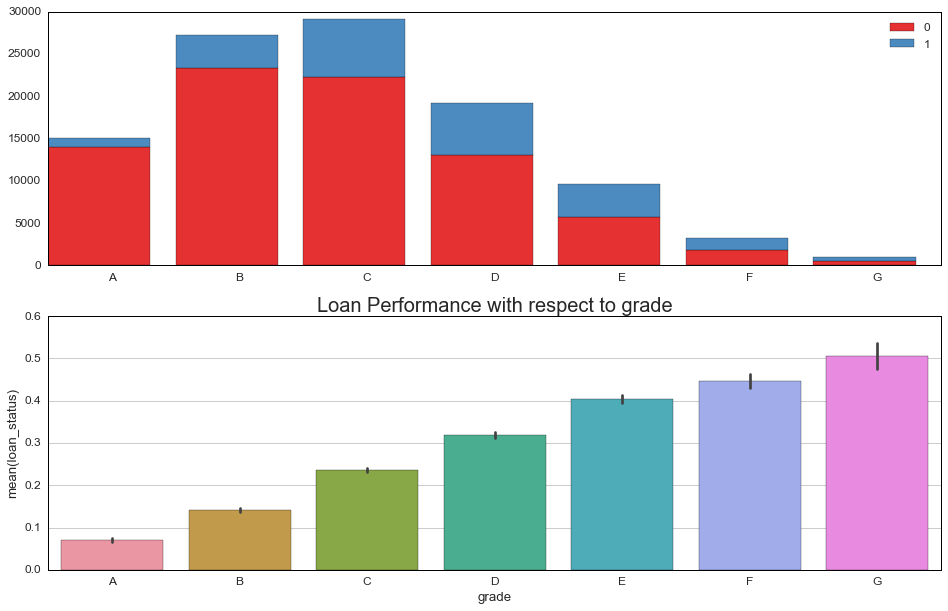

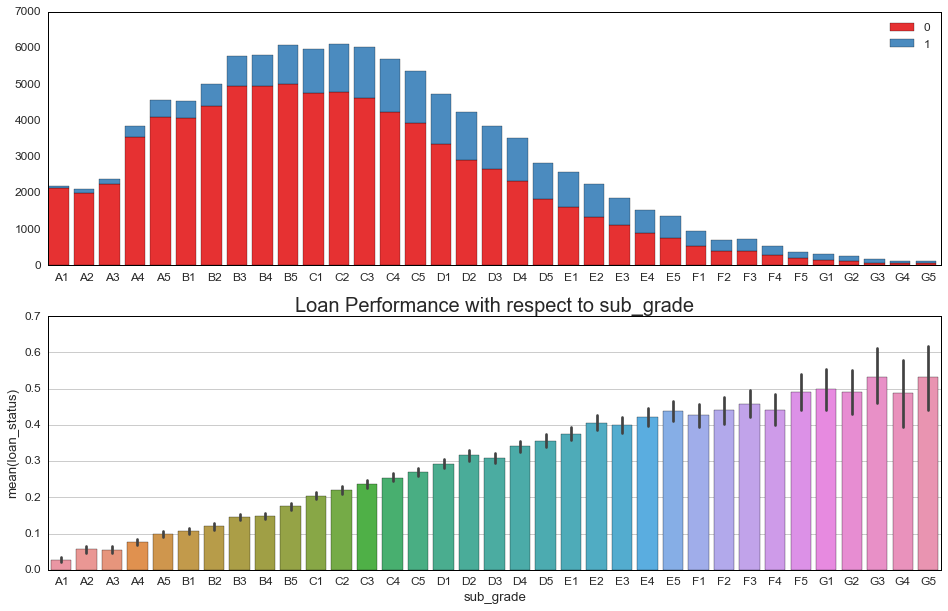

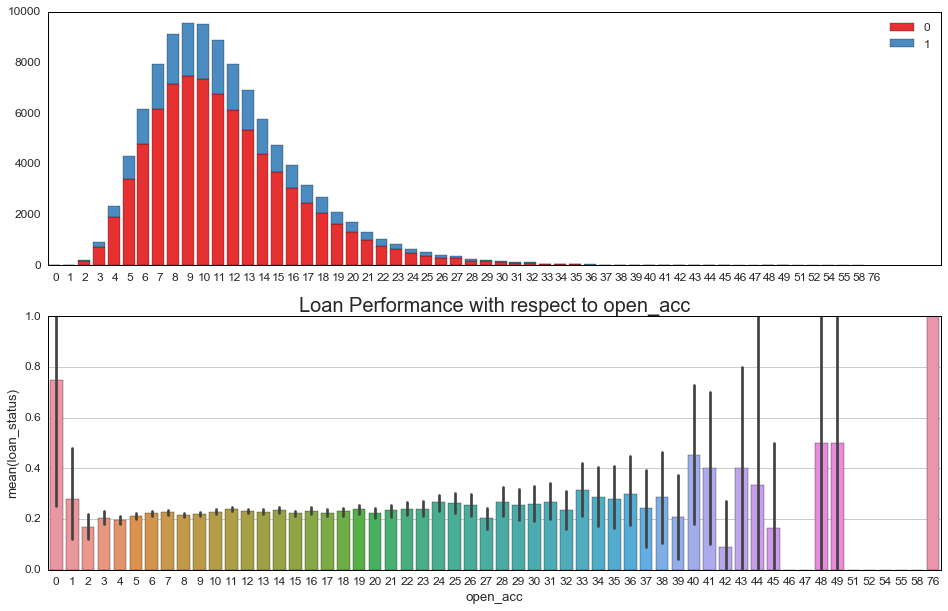

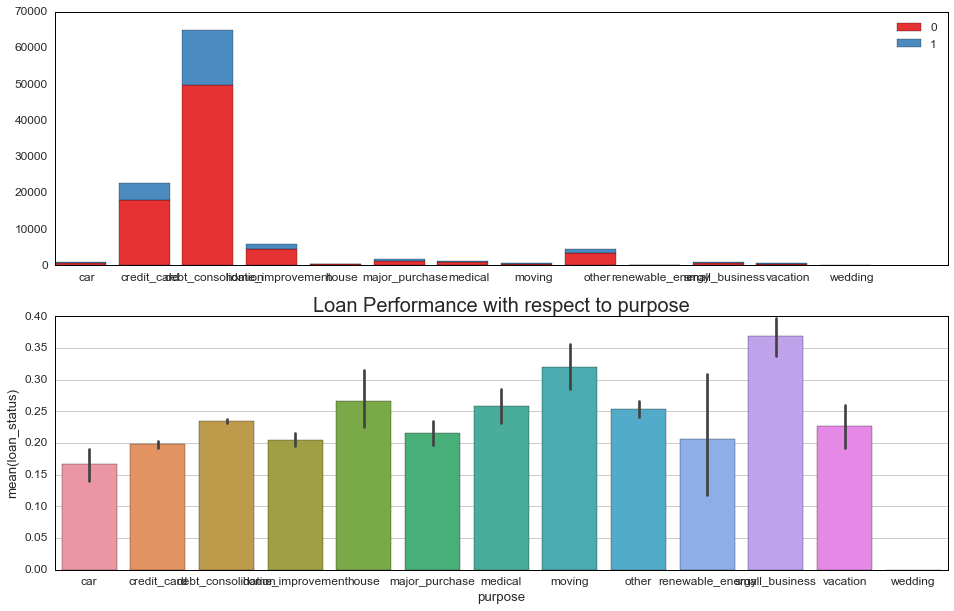

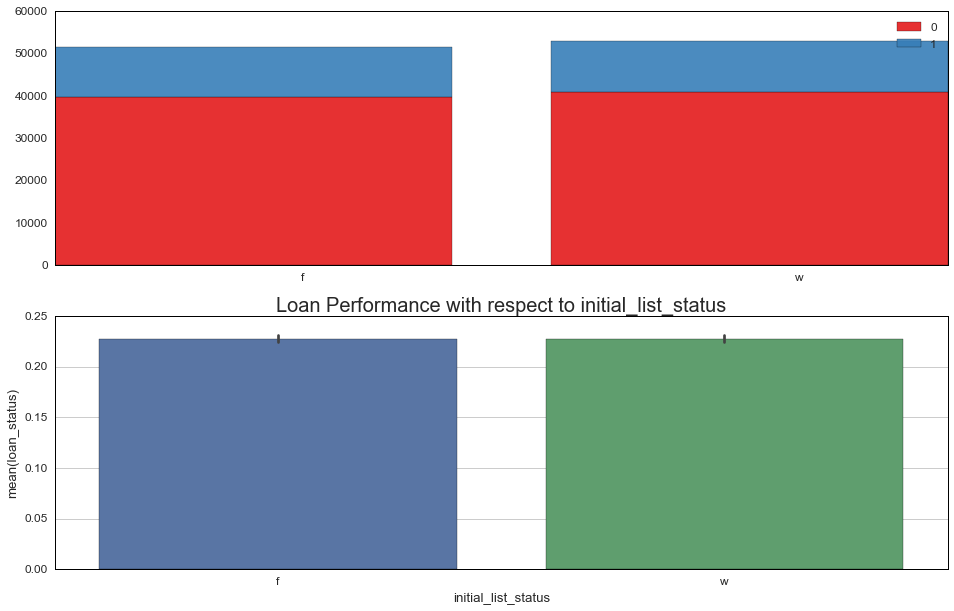

In [188]:
for feature in dummy_list:
    plot_bar(feature,df_all)

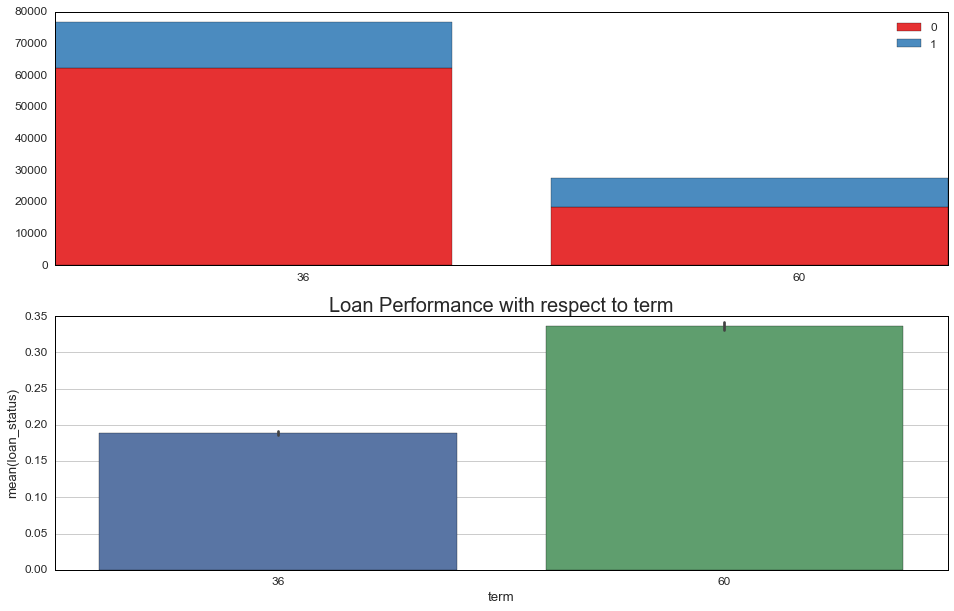

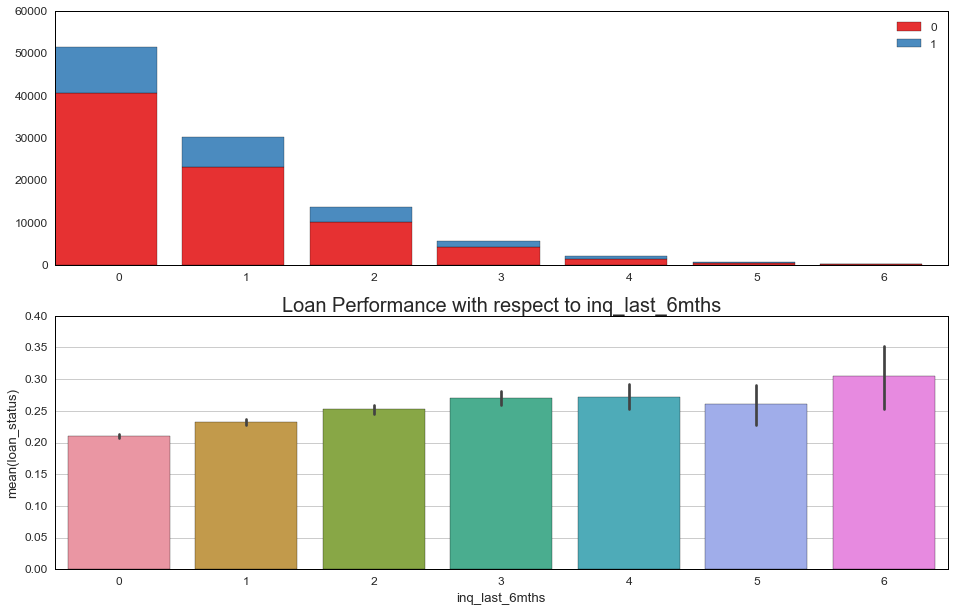

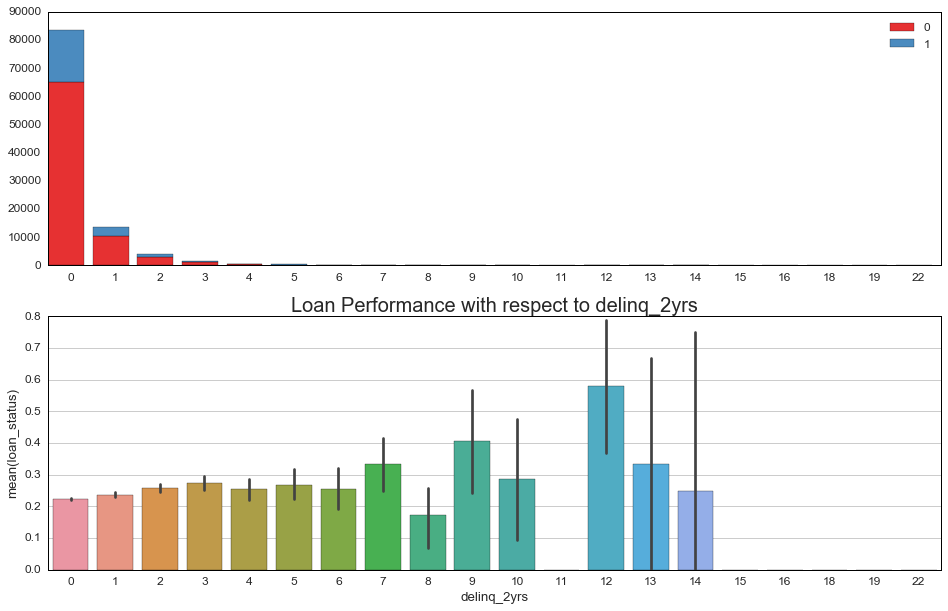

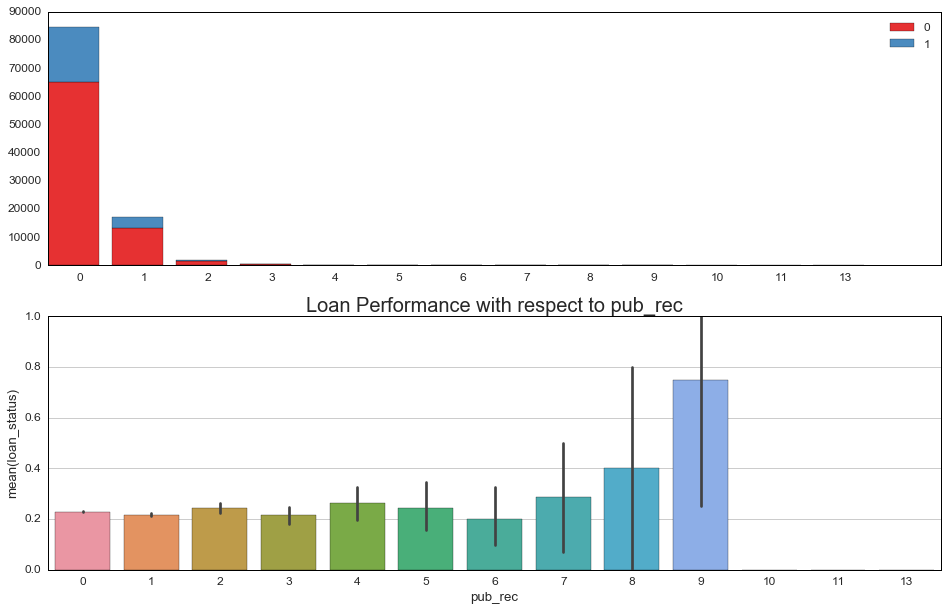

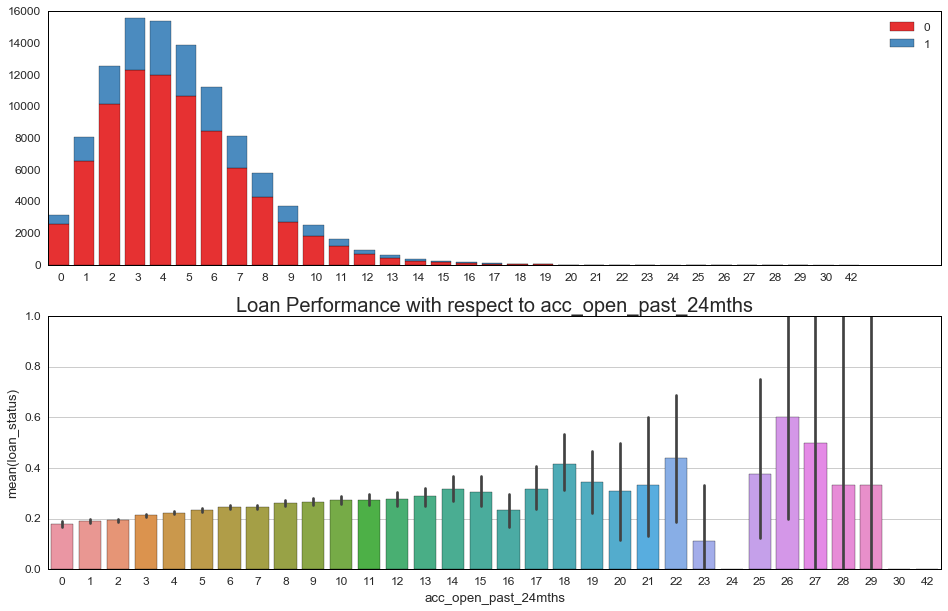

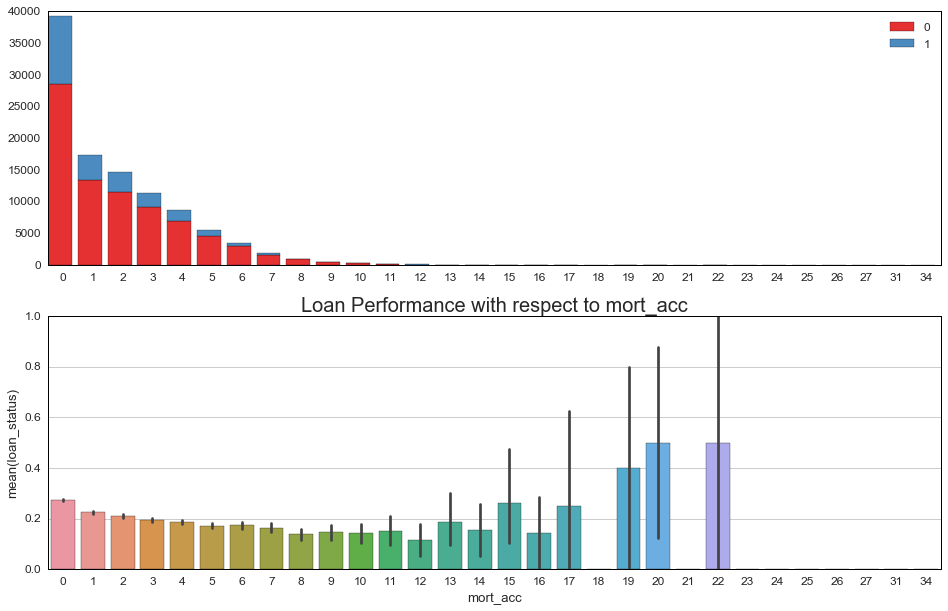

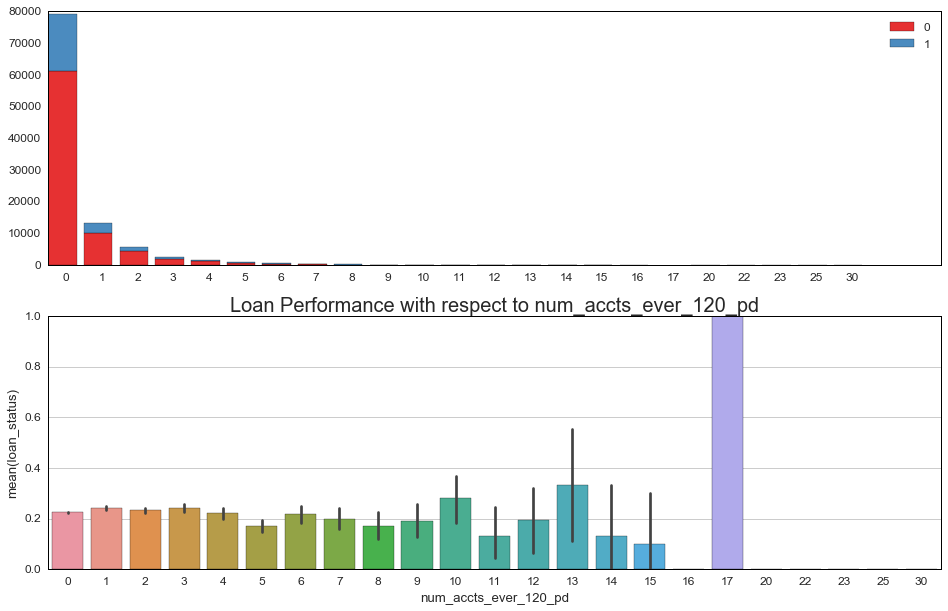

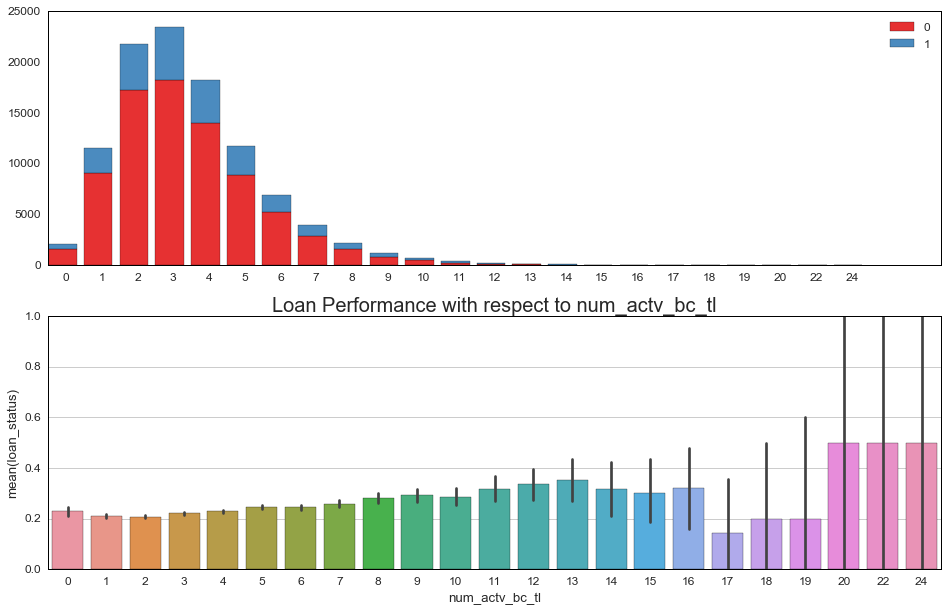

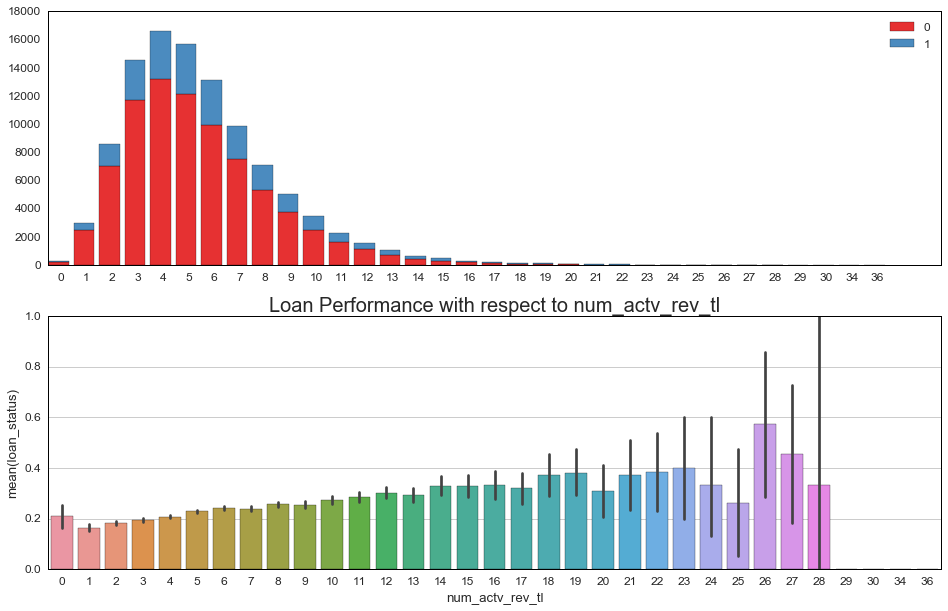

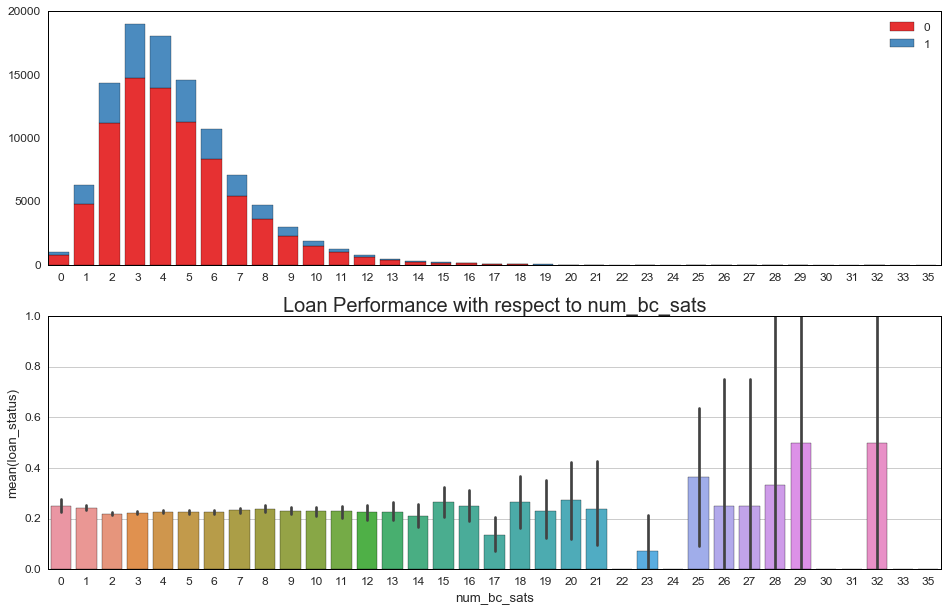

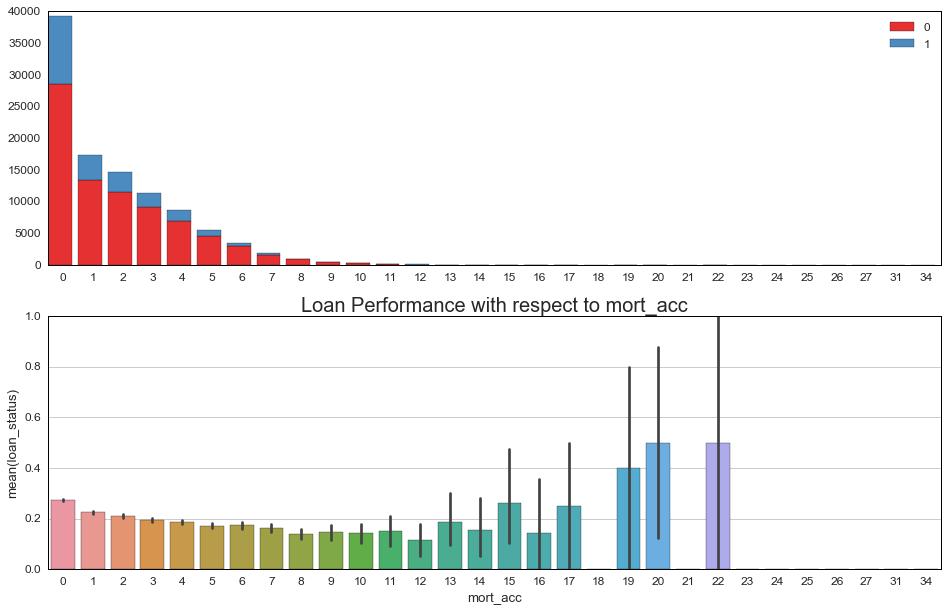

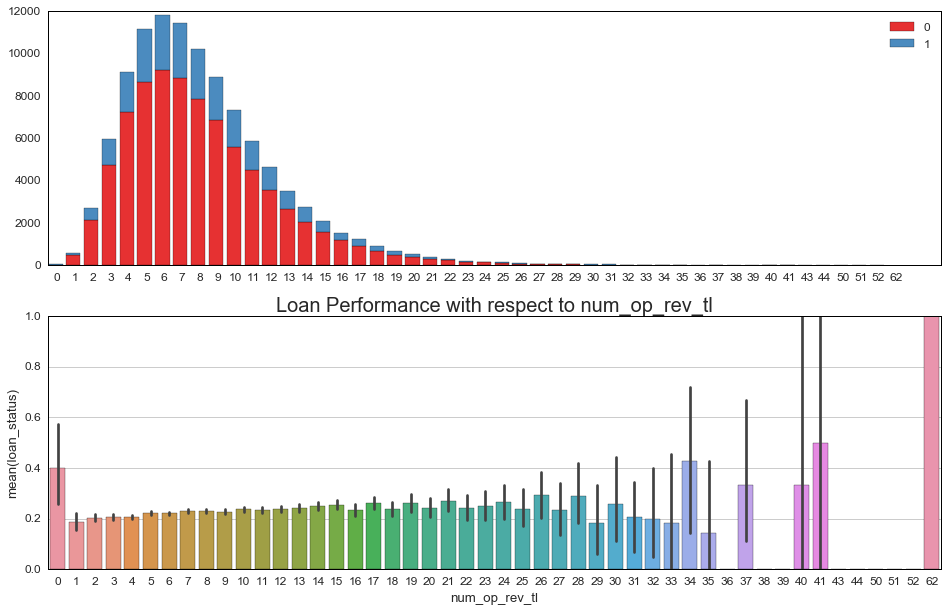

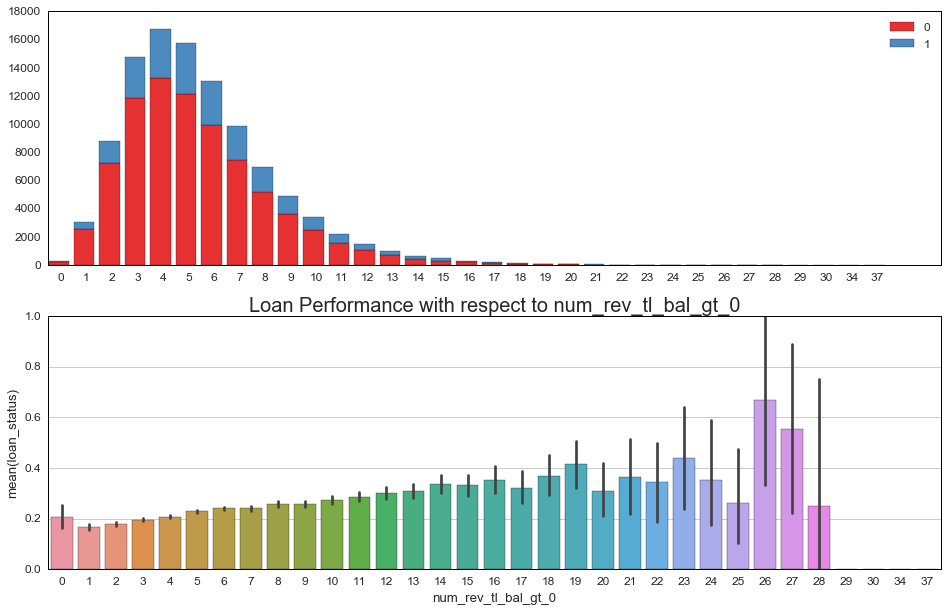

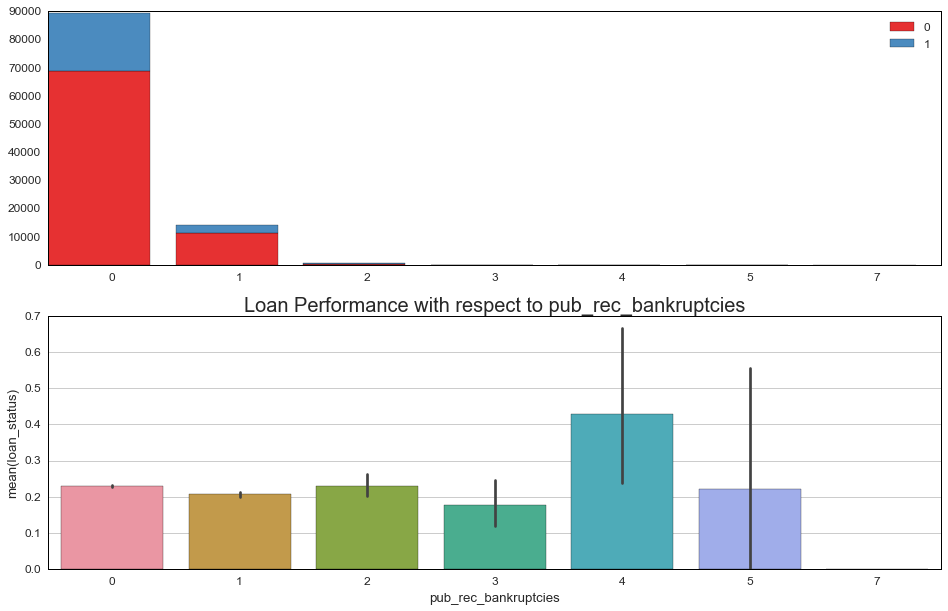

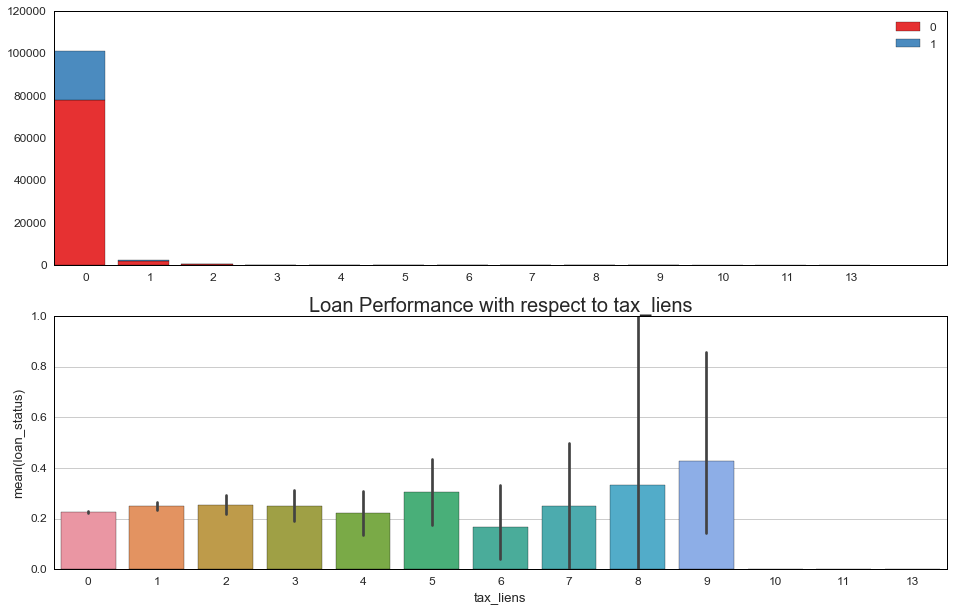

In [189]:
for feature in all_num_col:
    if df_all[feature].unique().shape[0]<50:
        plot_bar(feature,df_all)

data is too inbalanced
data is too inbalanced


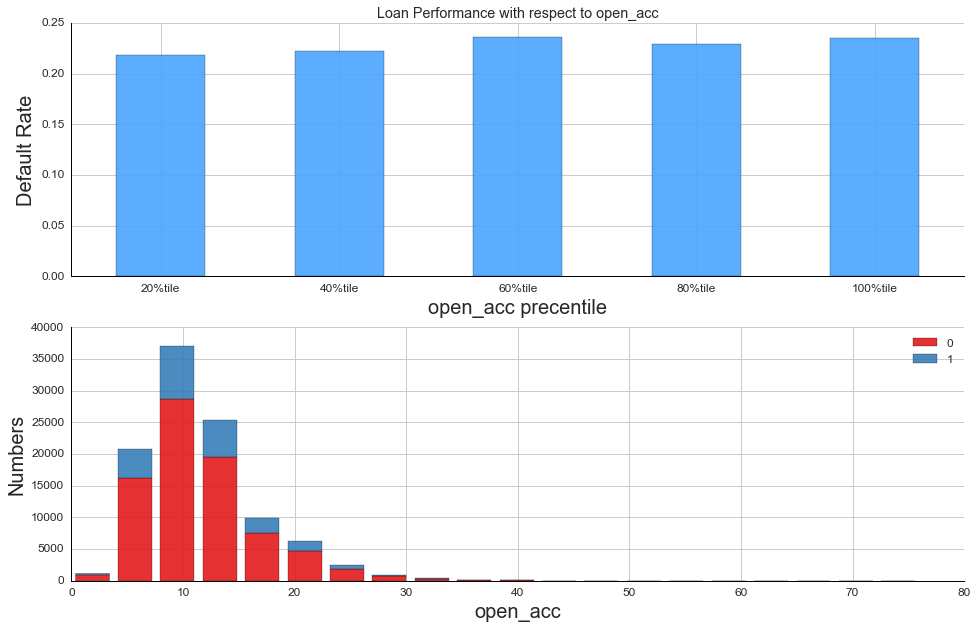

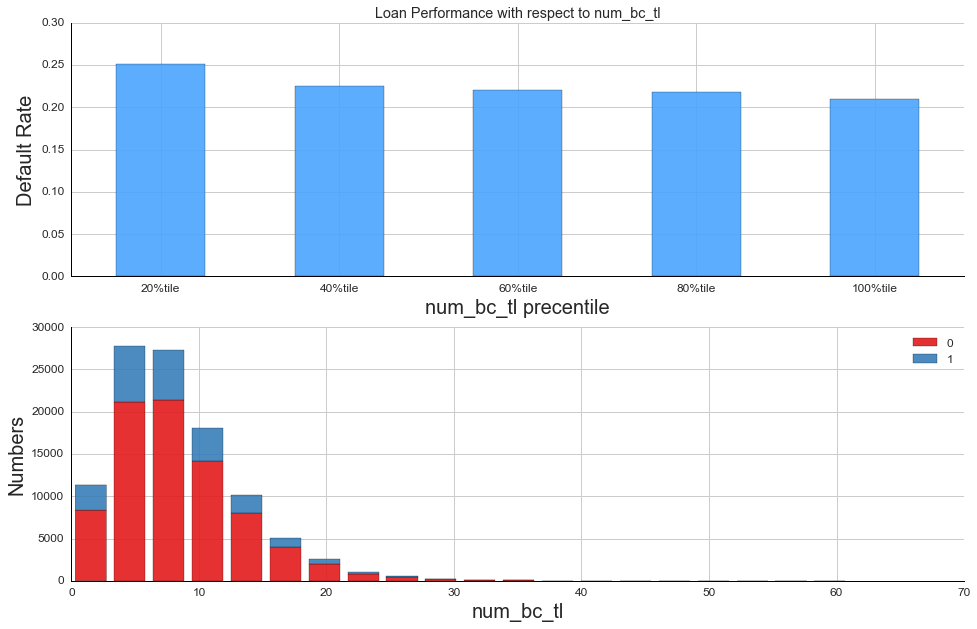

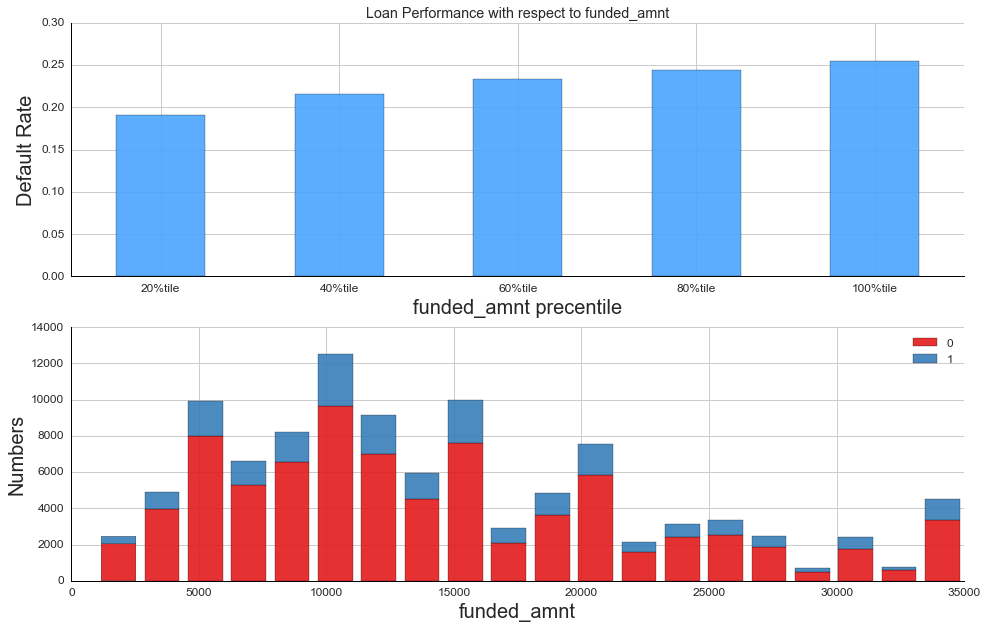

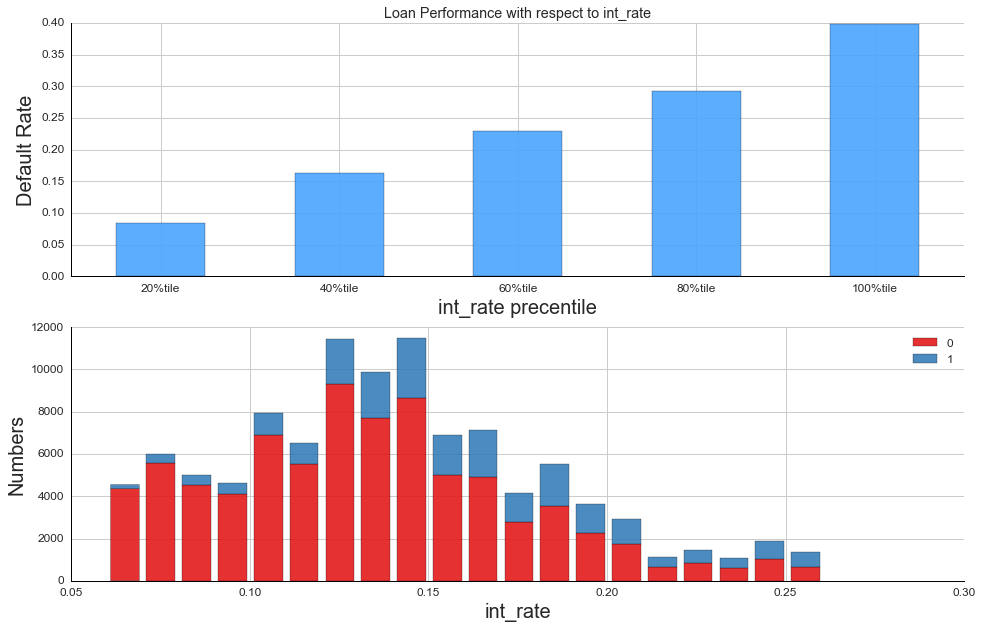

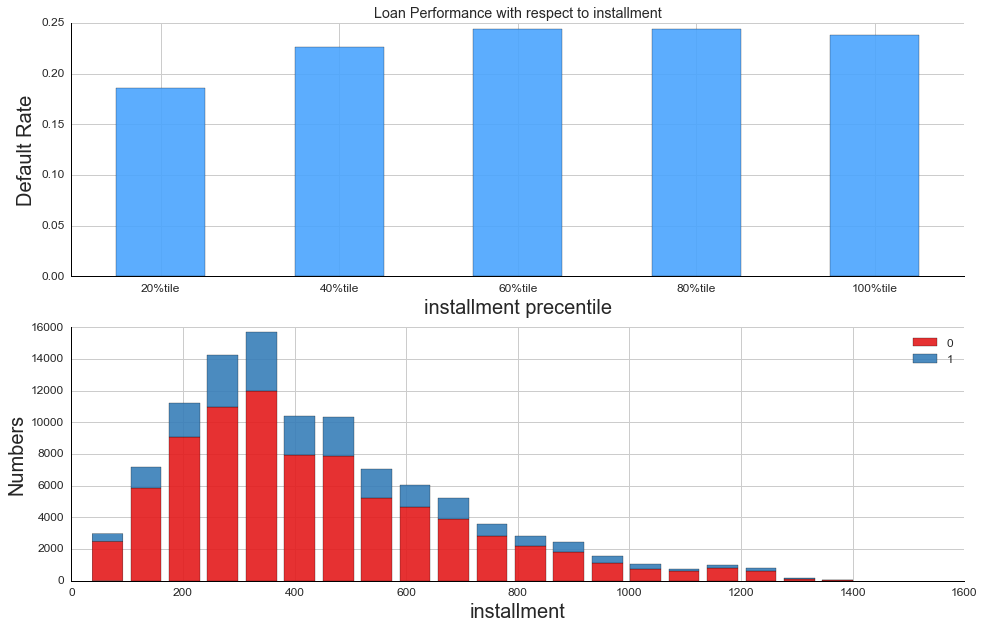

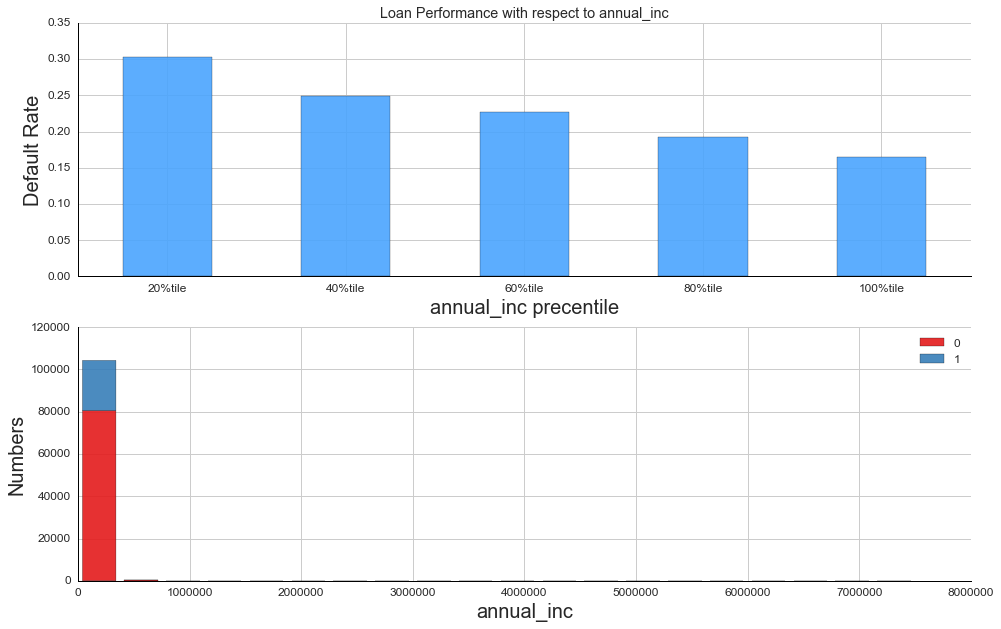

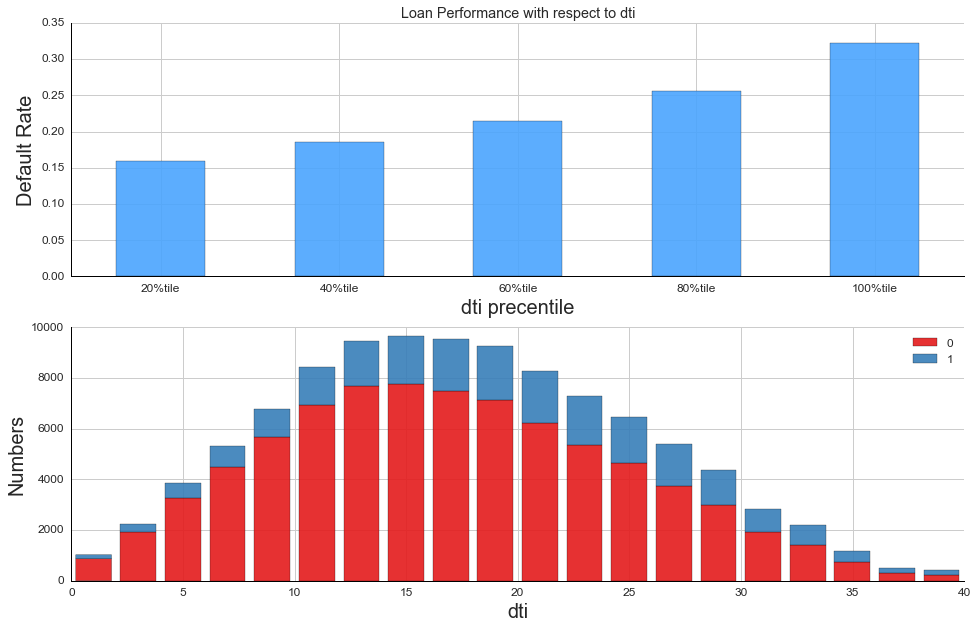

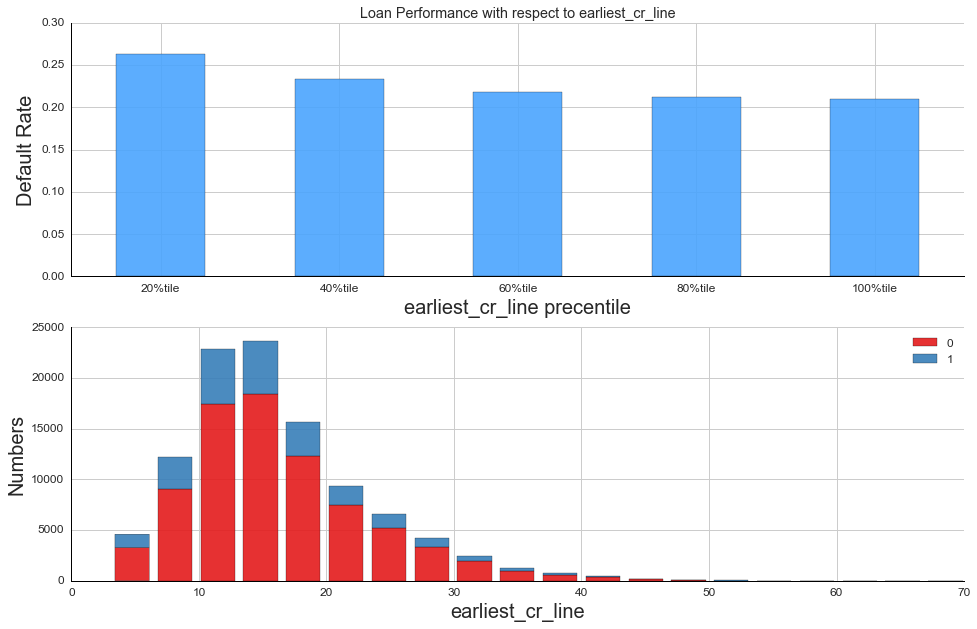

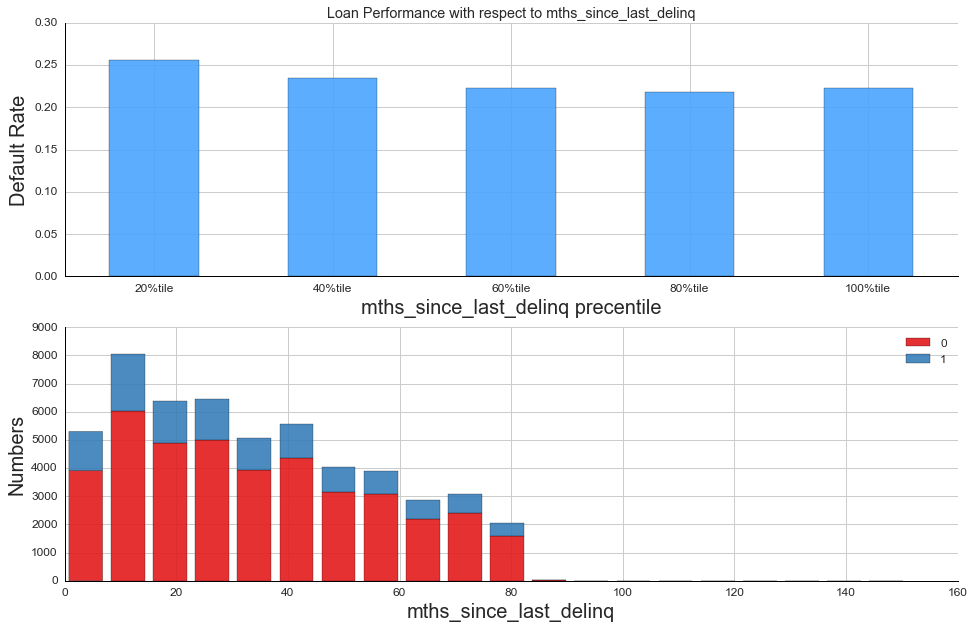

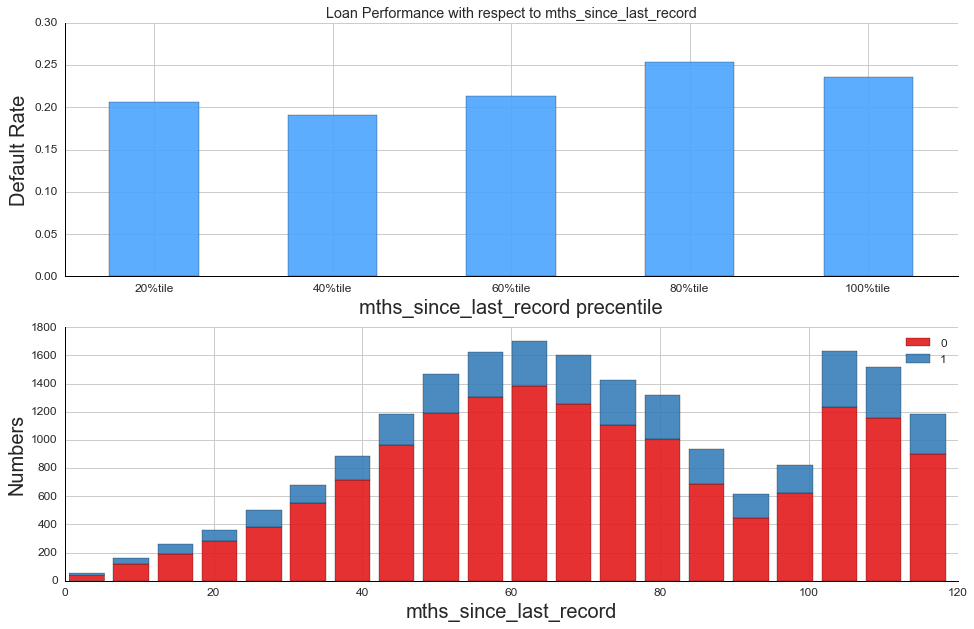

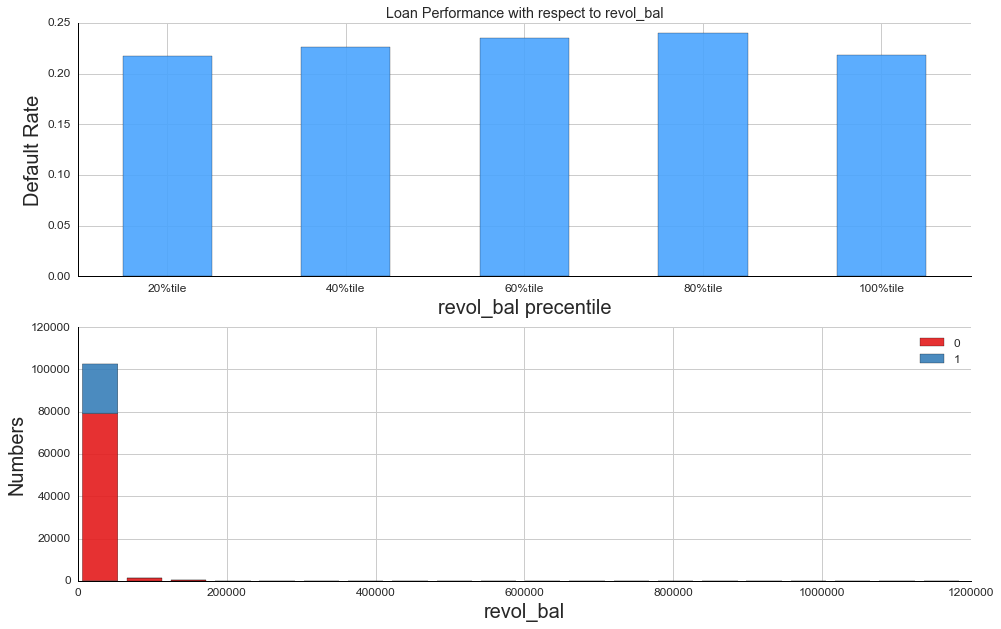

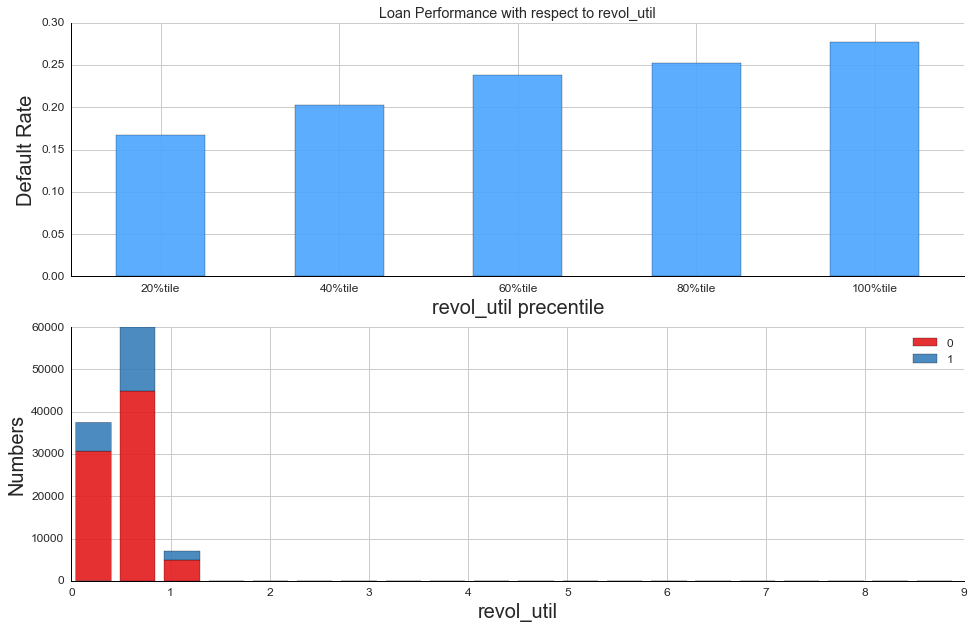

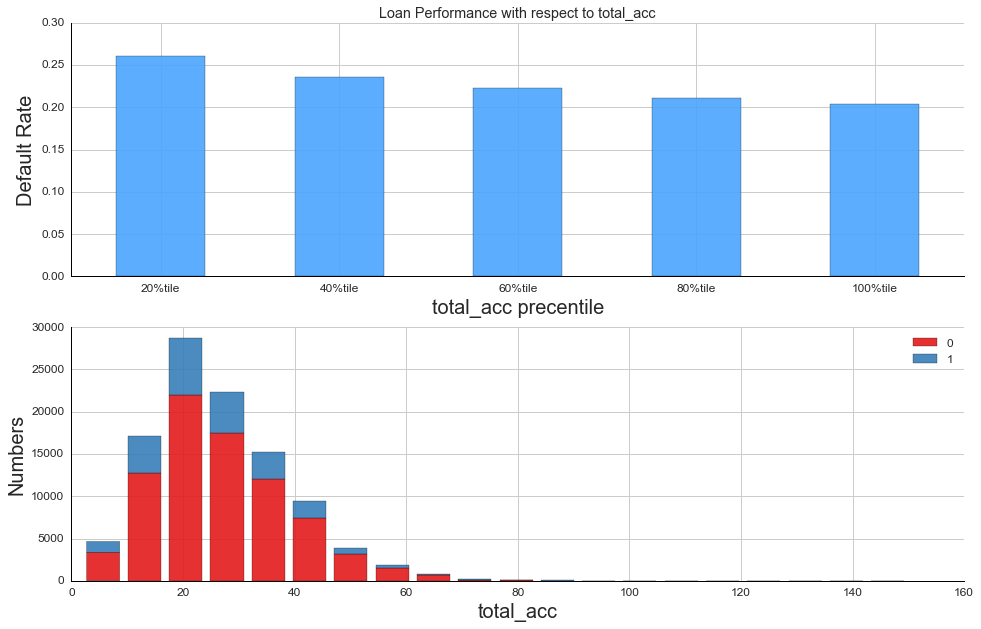

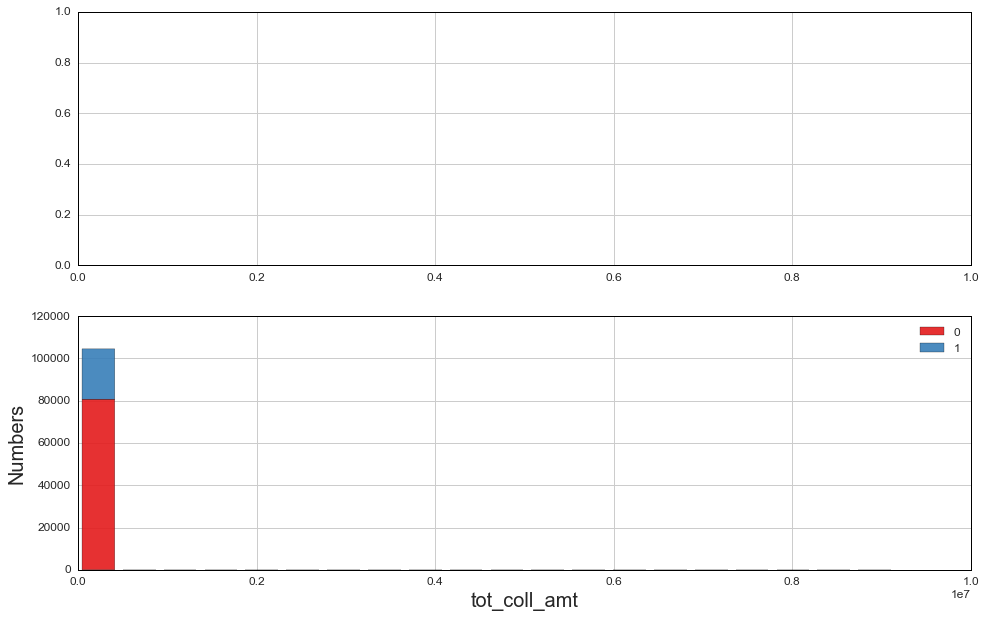

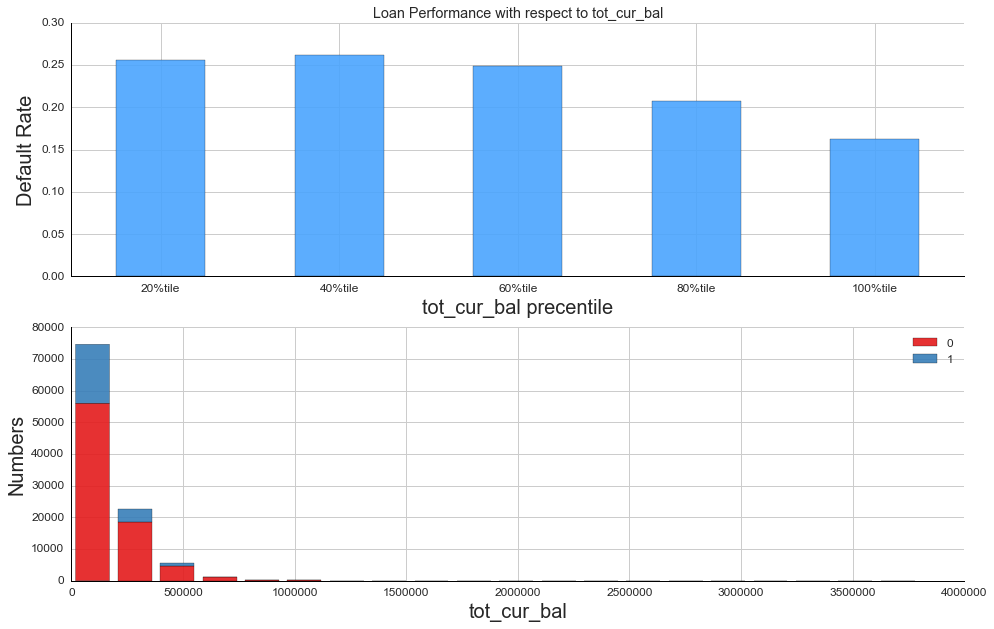

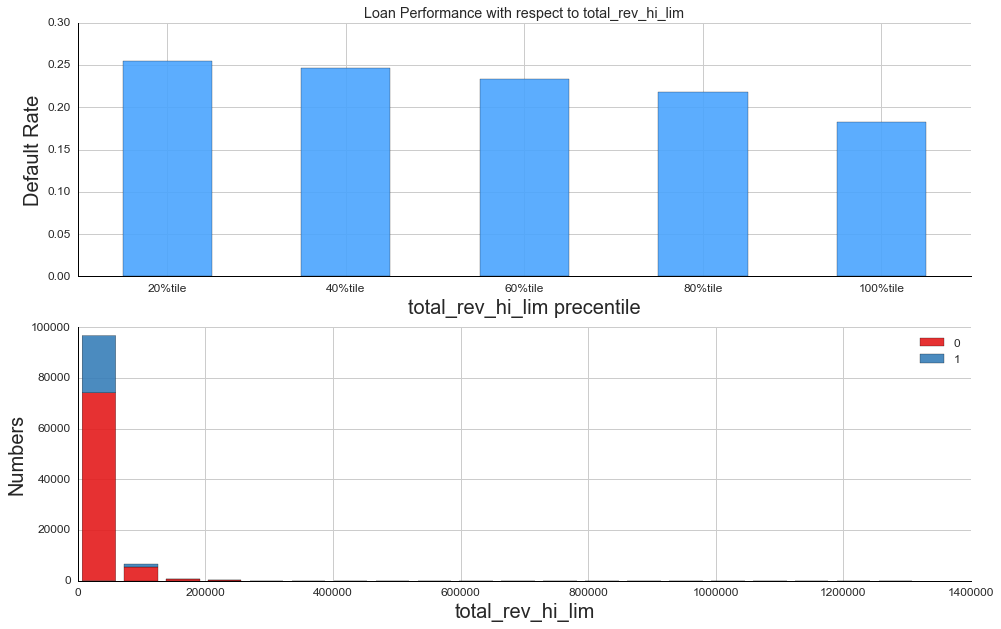

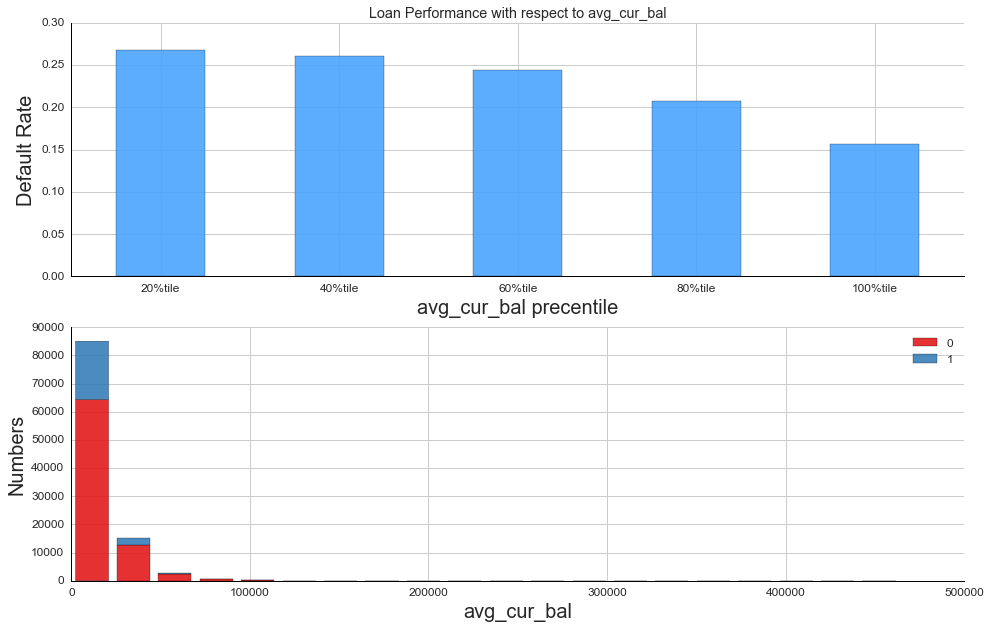

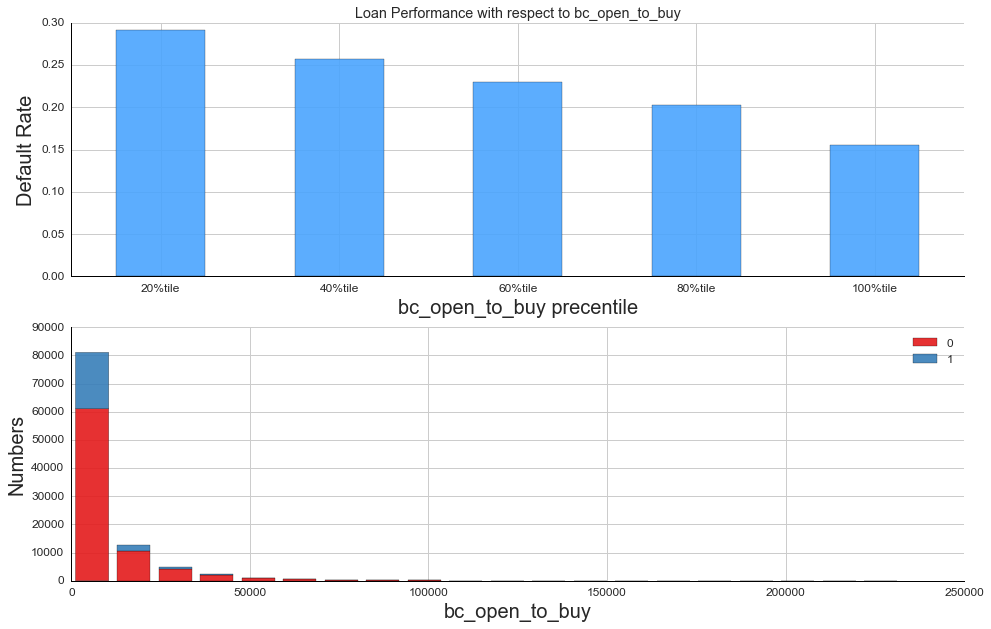

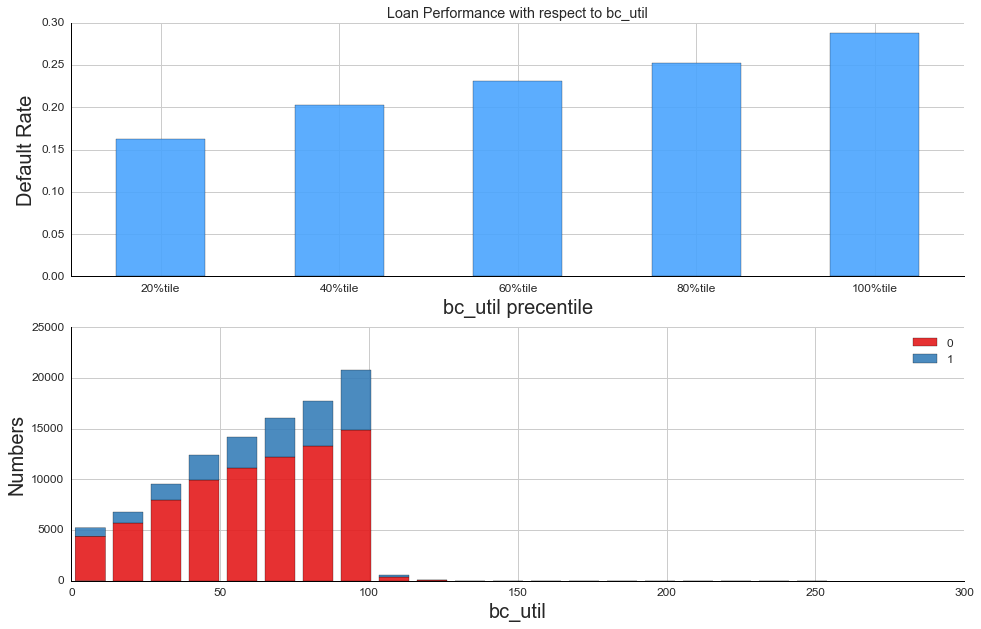

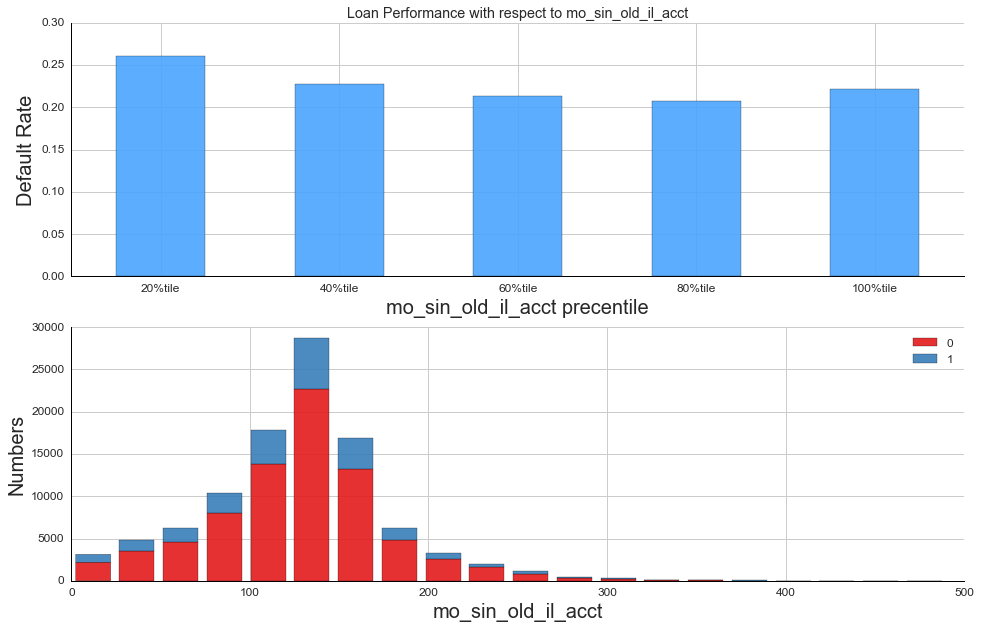

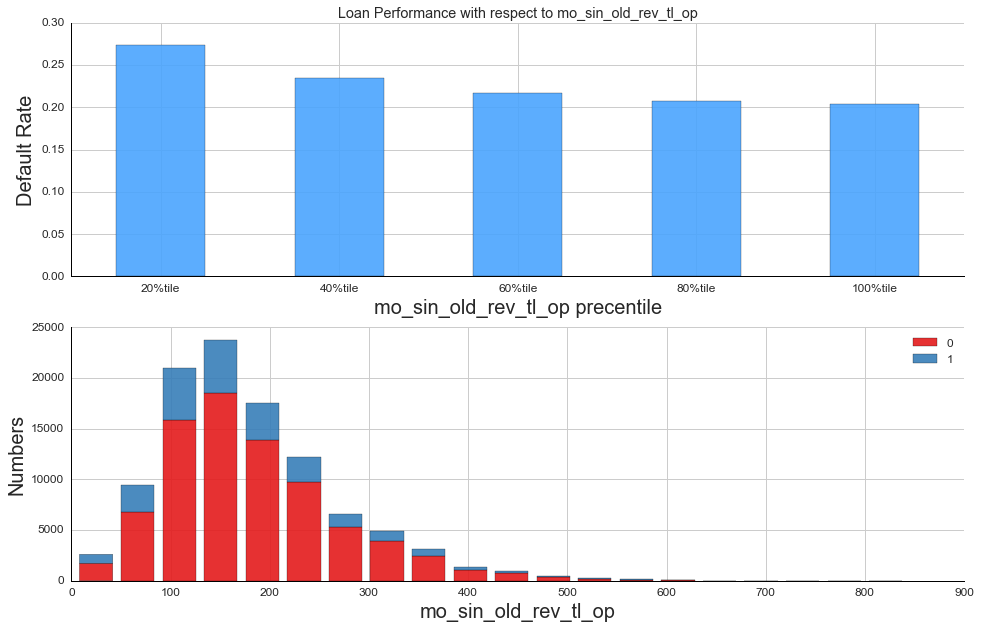

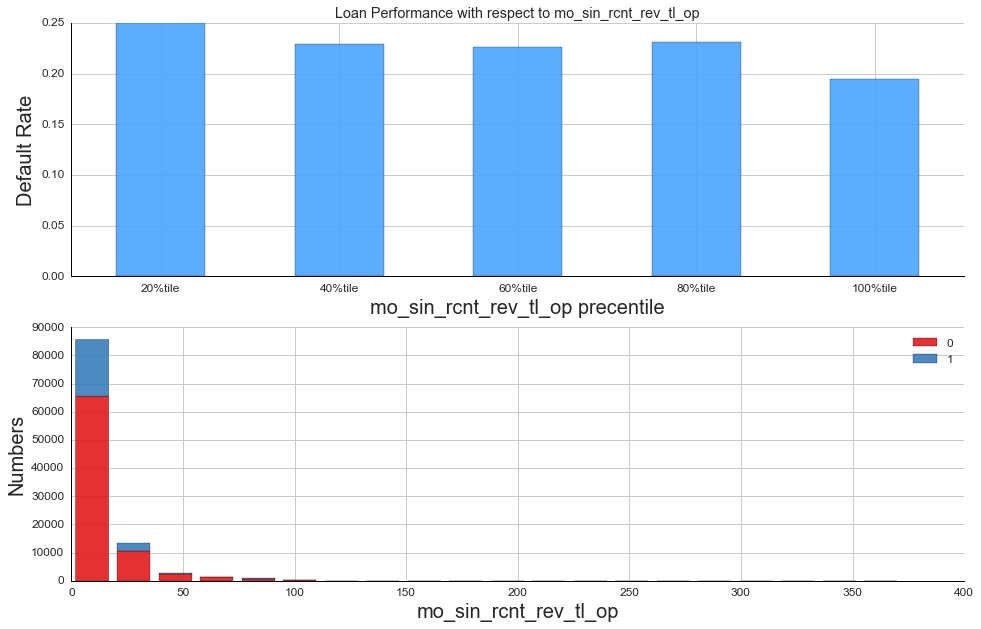

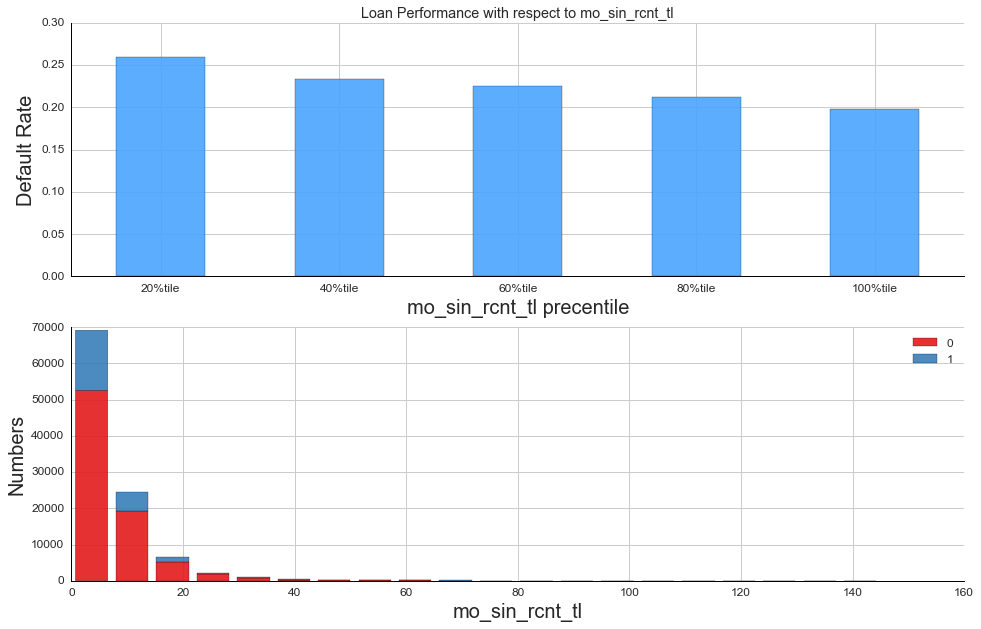

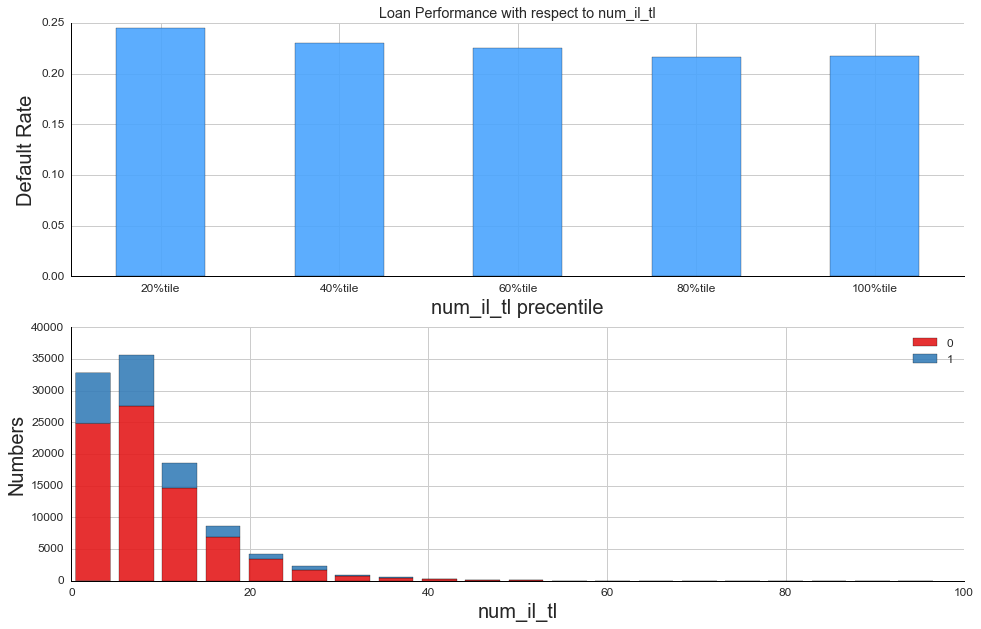

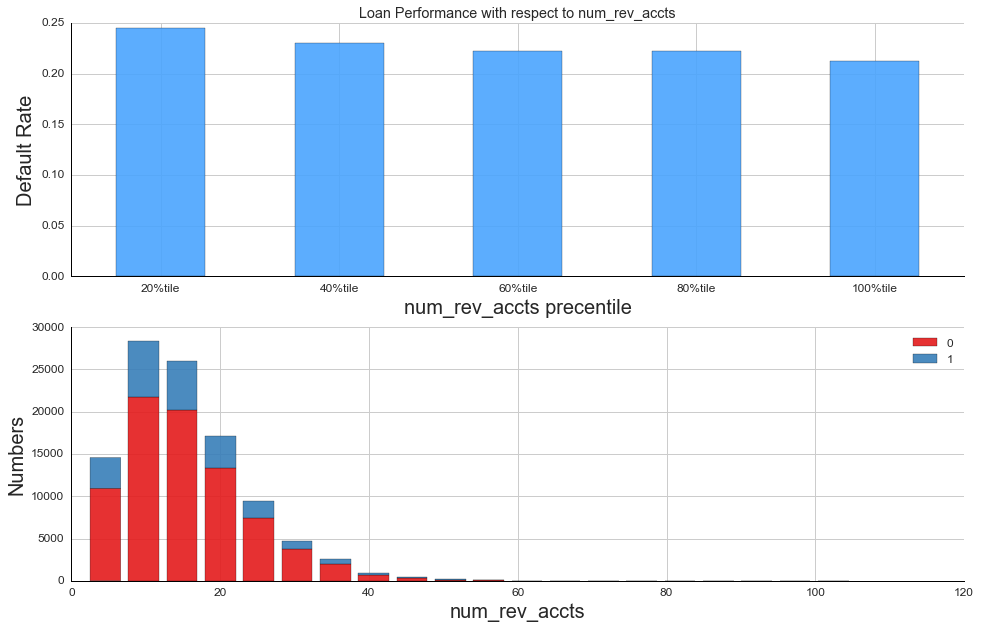

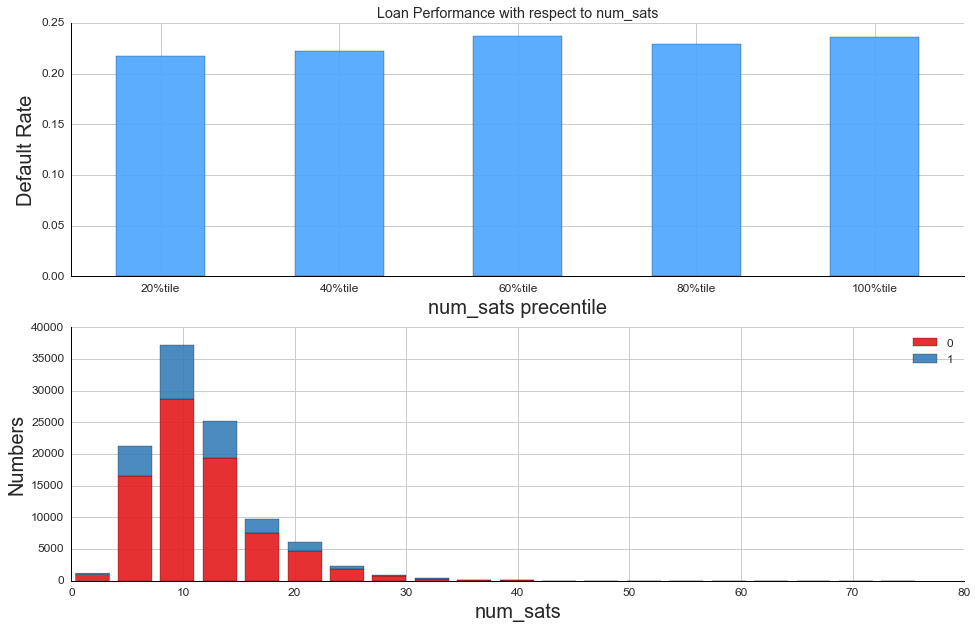

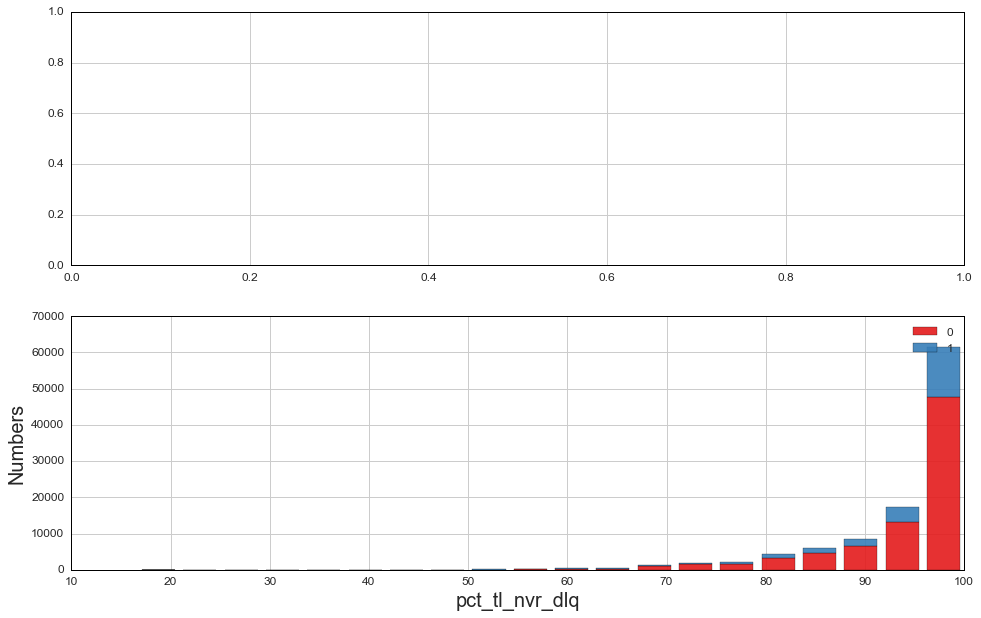

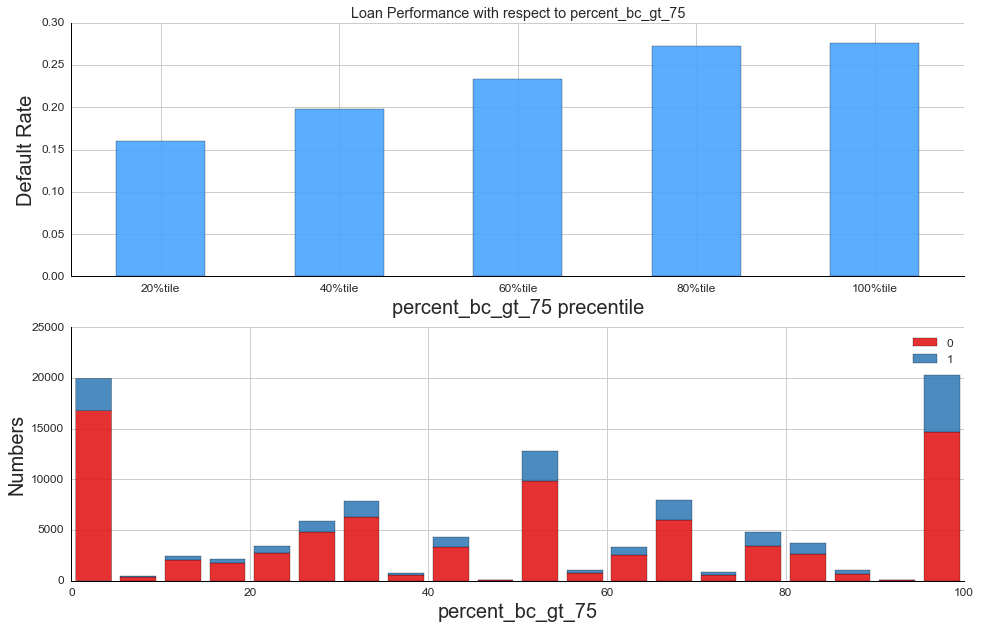

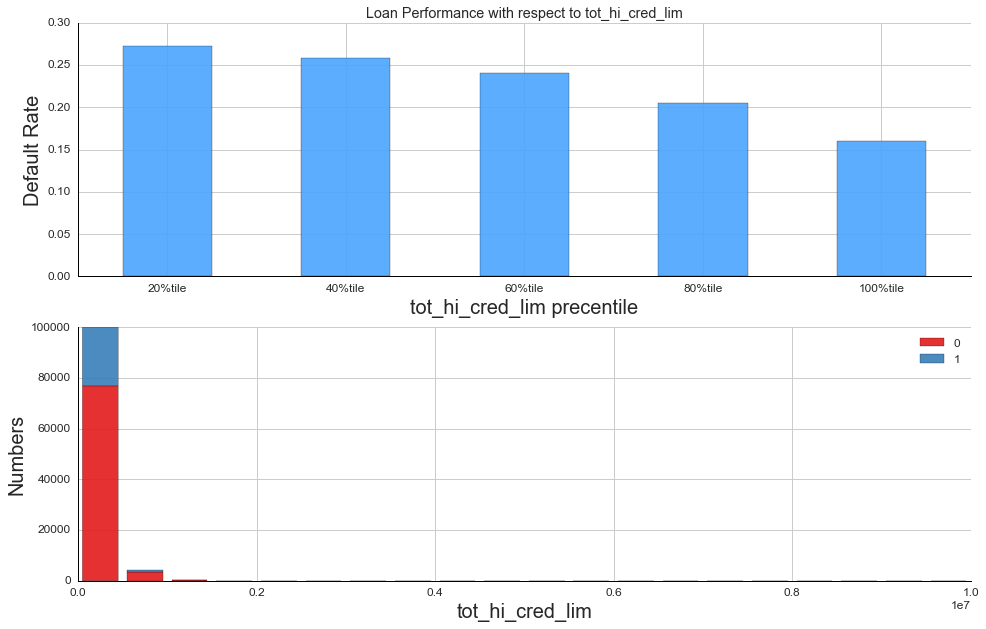

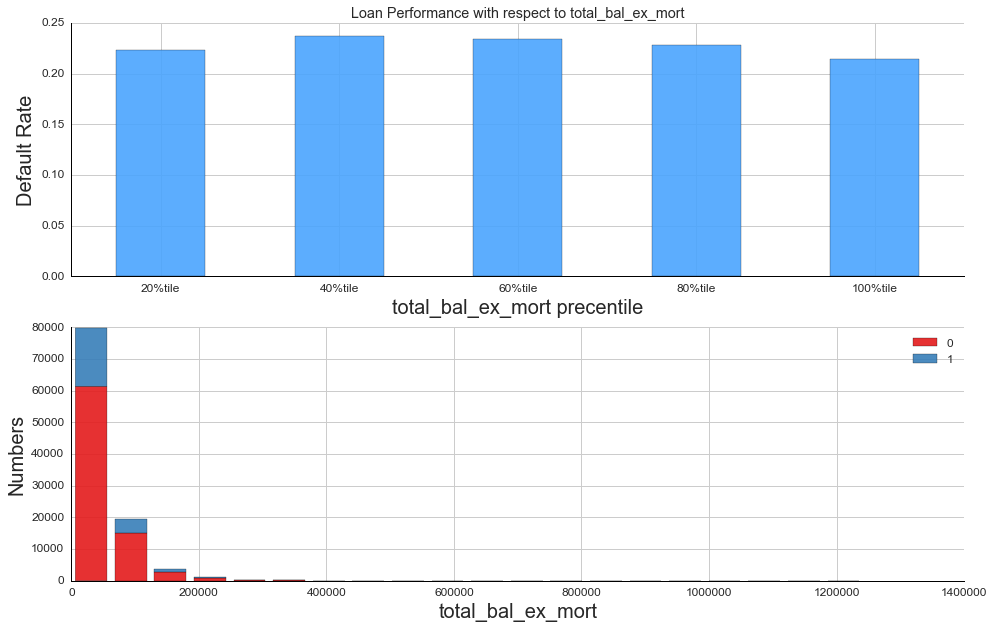

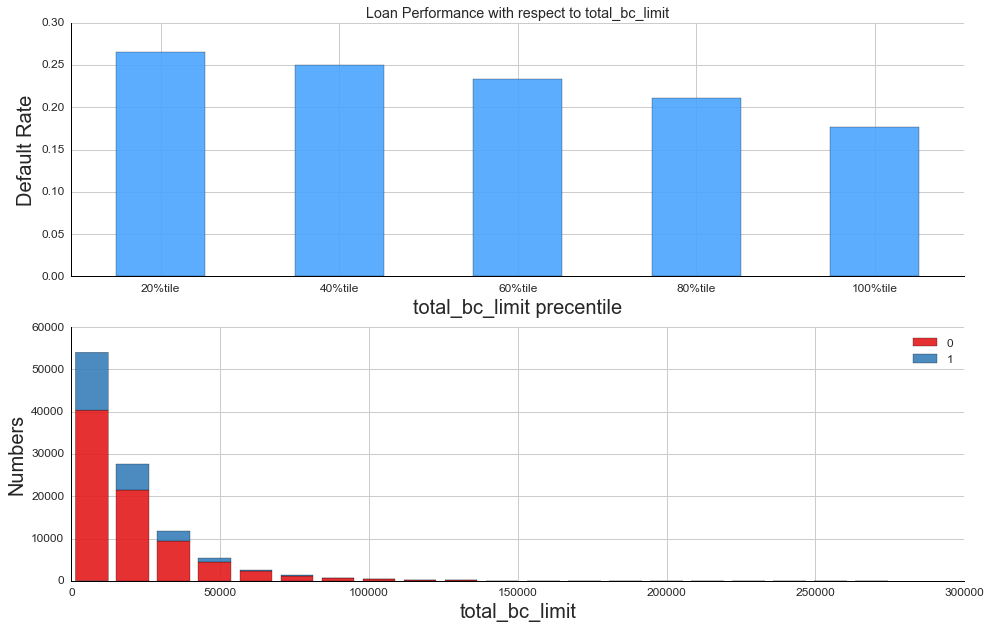

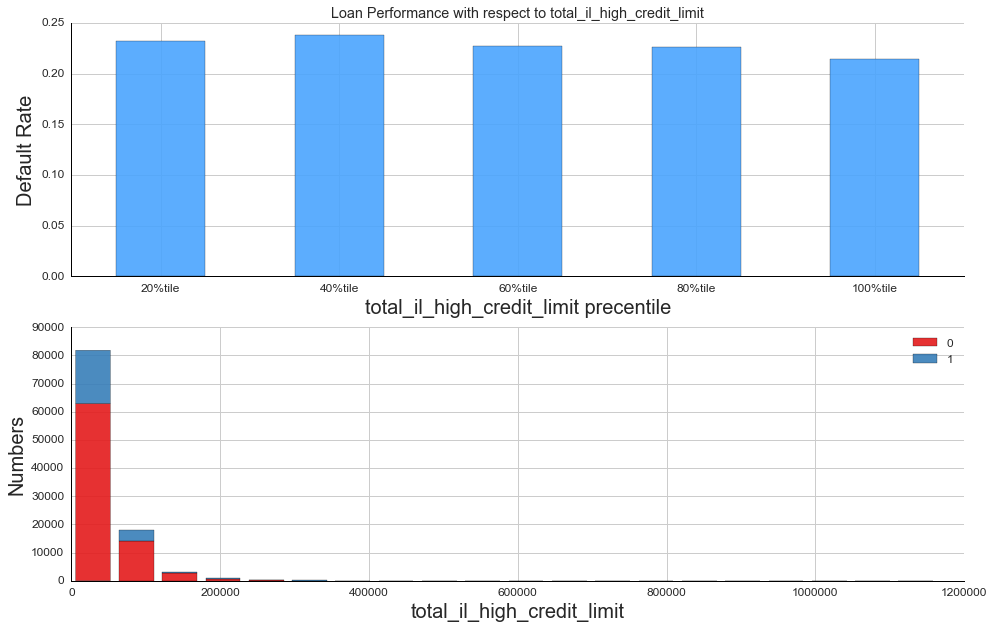

In [169]:
for feature in all_num_col:
    if df_all[feature].unique().shape[0]>=50:

        countinuous_variable_plot(feature)

------------
# Encoding

### For categorical feature use one-hot-encoding
### Then combined with numrical features

In [40]:
cat_cols = dummy_list

In [41]:
print df_all[cat_cols].shape
ohe=pd.get_dummies(df_all[cat_cols],sparse=False)
print ohe.shape

(104512, 8)
(104512, 112)


In [42]:
full_data = pd.concat([ohe,df_all[all_num_col+['loan_status','train_flg']]],axis=1)

In [43]:
full_data.head()

,emp_length,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,addr_state_AK,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,...,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,emp_title_freq,zip_code_freq,loan_status,train_flg
0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1,0,118369,108741,6600,107895,4.0,184,0,1
1,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,46193,30845,10100,28093,1.0,159,0,1
2,3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,231610,71226,14600,0,1.0,150,0,1
3,10,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,221776,112487,94000,120676,12.0,65,0,1
4,10,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,435367,36835,2700,37469,2.0,280,0,1


In [44]:
full_data = full_data.rename(columns = {'verification_status_Not Verified':'Not_Verified',
                            'verification_status_Source Verified':'Source_Verified',
                           'verification_status_Verified':'Verified'})

In [45]:
y = full_data['loan_status']

# Logistic Regression

In [49]:
X_train, X_val, y_train, y_val =  train_test_split(full_data[full_data['train_flg']==1].drop(['train_flg','loan_status'],axis=1), full_data[full_data['train_flg']==1]['loan_status'] , test_size=0.20 ,random_state =1122)

In [46]:
X_test = full_data[full_data['train_flg']==0].drop(['train_flg','loan_status'],axis=1)
y_test = full_data[full_data['train_flg']==0]['loan_status']
X_train_all = full_data[full_data['train_flg']==1].drop(['train_flg','loan_status'],axis=1)
y_train_all = full_data[full_data['train_flg']==1]['loan_status']

In [47]:
clf = LogisticRegression(penalty='l1')

In [50]:
start = time.time()

clf.fit(X_train.fillna(0),y_train)

print ("finished in %f seconds" %(time.time() - start))

finished in 2.830000 seconds


In [51]:
y_pred_train = clf.predict_proba(X_train.fillna(0))

In [52]:
fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_train[:,1])

In [53]:
y_pred_val = clf.predict_proba(X_val.fillna(0))

In [54]:
fpr_val, tpr_val, _ = roc_curve(y_val, y_pred_val[:,1])

In [55]:
y_pred = clf.predict_proba(X_test.fillna(0))

In [56]:
fpr_test, tpr_test, _ = roc_curve(y_test, y_pred[:,1])

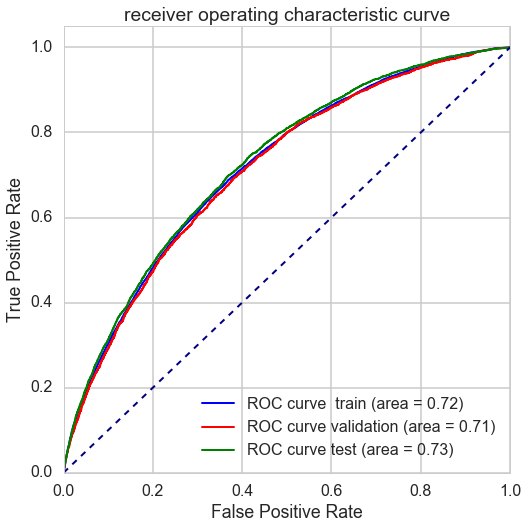

In [57]:
plt.figure(figsize=(8, 8))
lw=2
plt.plot(fpr_train, tpr_train, color='blue',
         lw=lw, label='ROC curve  train (area = %0.2f)' % roc_auc_score(y_train, y_pred_train[:,1]))

plt.plot(fpr_val, tpr_val, color='red',
         lw=lw, label='ROC curve validation (area = %0.2f)' % roc_auc_score(y_val, y_pred_val[:,1]))

plt.plot(fpr_test, tpr_test, color='green',
         lw=lw, label='ROC curve test (area = %0.2f)' % roc_auc_score(y_test, y_pred[:,1]))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()

# XGboost

In [58]:
def fpreproc(dtrain,dtest,param):
    label = dtrain.get_label()
    ratio = float(np.sum(label ==0))/np.sum(label ==1)
    param['scale_pos_weight'] = ratio
    return (dtrain,dtest,param)

In [59]:
X_dtest = xgb.DMatrix(X_test,missing =np.NAN)
X_dtrain_all = xgb.DMatrix(X_train_all,label=y_train_all,missing =np.NAN)
watchlist  = [(X_dtrain_all,'train')] 

In [63]:
def score(params):
    print "=========================="
    print time.asctime()
    print "=========================="
    
    start = time.time()
    
    print "Training with params : "
    print params
    num_round = int(params['n_estimators'])
    params['max_depth'] = int (params['max_depth'])
    del params['n_estimators'] ## here is to converst the n_estimators to num_round
    
    early_stopping_rounds
    
    gbmcv = xgb.cv(params,X_dtrain_all,num_round, nfold =5, metrics=['auc'],seed=12,fpreproc = fpreproc,early_stopping_rounds=early_stopping_rounds)
    
    print ("\nfinished in %f seconds" %(time.time() - start))  
    score = gbmcv['test-auc-mean'].max()
    print('Average eval-auc: %.6f\n\n' % score)
    return {'loss': -1*score, 'status': STATUS_OK}

In [64]:
def optimize(trials):
    space = {
             'n_estimators' : 10000,
             'eta' : hp.quniform('eta', 0.025, 0.5, 0.025),
             'max_depth' : hp.quniform('max_depth', 4, 10, 1),
             'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1),
             'subsample' : hp.quniform('subsample', 0.4, 1, 0.05),
             'gamma' : hp.quniform('gamma', 0.0, 1, 0.05),
             'colsample_bytree' : hp.quniform('colsample_bytree', 0.4, 1, 0.05),
             'eval_metric': 'auc',
             'objective': 'binary:logistic',
             'silent' : 1
             }

    best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=50)

    print best

In [65]:
trials = Trials()

optimize(trials)

Sat Oct 22 22:13:15 2016
Training with params : 
{'colsample_bytree': 0.45, 'silent': 1, 'eval_metric': 'auc', 'min_child_weight': 6.0, 'n_estimators': 10000, 'subsample': 0.55, 'eta': 0.375, 'objective': 'binary:logistic', 'max_depth': 6.0, 'gamma': 0.45}

finished in 10.179000 seconds
Average eval-auc: 0.703369


Sat Oct 22 22:13:25 2016
Training with params : 
{'colsample_bytree': 0.4, 'silent': 1, 'eval_metric': 'auc', 'min_child_weight': 2.0, 'n_estimators': 10000, 'subsample': 0.65, 'eta': 0.375, 'objective': 'binary:logistic', 'max_depth': 8.0, 'gamma': 0.5}

finished in 10.243000 seconds
Average eval-auc: 0.691162


Sat Oct 22 22:13:35 2016
Training with params : 
{'colsample_bytree': 0.8500000000000001, 'silent': 1, 'eval_metric': 'auc', 'min_child_weight': 3.0, 'n_estimators': 10000, 'subsample': 0.9500000000000001, 'eta': 0.17500000000000002, 'objective': 'binary:logistic', 'max_depth': 10.0, 'gamma': 0.6000000000000001}

finished in 32.428000 seconds
Average eval-auc: 0.699

In [66]:
param = {'max_depth':5, 'eta':0.025, 'silent':1, 'objective':'binary:logistic','gamma' : 0.8}
param['eval_metric'] = 'auc'
param['subsample'] = 0.7
param['colsample_bytree']= 0.45
param['min_child_weight'] = 3
param['booster'] = "gbtree"

num_round = 1000


In [67]:
gbmcv = xgb.cv(param,X_dtrain_all,num_round, nfold =5, metrics=['auc'],seed=12,fpreproc = fpreproc,early_stopping_rounds=10)

In [72]:
gbmcv.shape

(515, 4)

In [73]:
watchlist  = [(X_dtrain_all,'train')] 
bst = xgb.train(param, X_dtrain_all,515,watchlist )

[0]	train-auc:0.649835
[1]	train-auc:0.686251
[2]	train-auc:0.704915
[3]	train-auc:0.707138
[4]	train-auc:0.707515
[5]	train-auc:0.708874
[6]	train-auc:0.710504
[7]	train-auc:0.710781
[8]	train-auc:0.711368
[9]	train-auc:0.713512
[10]	train-auc:0.713262
[11]	train-auc:0.713355
[12]	train-auc:0.713478
[13]	train-auc:0.715255
[14]	train-auc:0.716105
[15]	train-auc:0.715767
[16]	train-auc:0.716263
[17]	train-auc:0.716449
[18]	train-auc:0.716994
[19]	train-auc:0.717362
[20]	train-auc:0.717264
[21]	train-auc:0.717155
[22]	train-auc:0.717093
[23]	train-auc:0.717221
[24]	train-auc:0.717301
[25]	train-auc:0.717165
[26]	train-auc:0.717214
[27]	train-auc:0.717523
[28]	train-auc:0.717987
[29]	train-auc:0.717861
[30]	train-auc:0.717859
[31]	train-auc:0.718105
[32]	train-auc:0.718644
[33]	train-auc:0.718394
[34]	train-auc:0.718555
[35]	train-auc:0.718654
[36]	train-auc:0.718506
[37]	train-auc:0.718826
[38]	train-auc:0.718847
[39]	train-auc:0.71902
[40]	train-auc:0.719358
[41]	train-auc:0.719468
[42

In [74]:
y_pred_train_all = bst.predict(X_dtrain_all)
fpr_train, tpr_train, _ = roc_curve(y_train_all, y_pred_train_all)
y_pred =  bst.predict(X_dtest)
fpr_test, tpr_test, _ = roc_curve(y_test, y_pred)

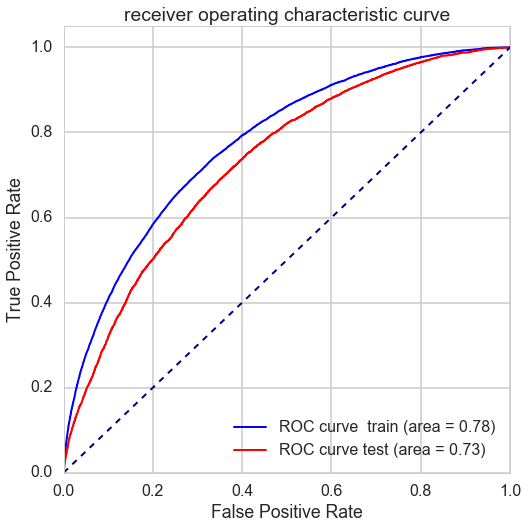

In [75]:
plt.figure(figsize=(8, 8))
lw=2
plt.plot(fpr_train, tpr_train, color='blue',
         lw=lw, label='ROC curve  train (area = %0.2f)' % roc_auc_score(y_train_all,y_pred_train_all))

plt.plot(fpr_test, tpr_test, color='red',
         lw=lw, label='ROC curve test (area = %0.2f)' % roc_auc_score(y_test, y_pred ))


plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()

In [76]:
features = list(X_train_all.columns)

In [77]:
def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    i = 0
    for feat in features:
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
        i = i + 1
    outfile.close()

In [78]:
create_feature_map(features)

In [79]:
importance = bst.get_fscore(fmap="xgb.fmap")
importance = sorted(importance.items(),key=operator.itemgetter(1))

In [80]:
len(importance)

145

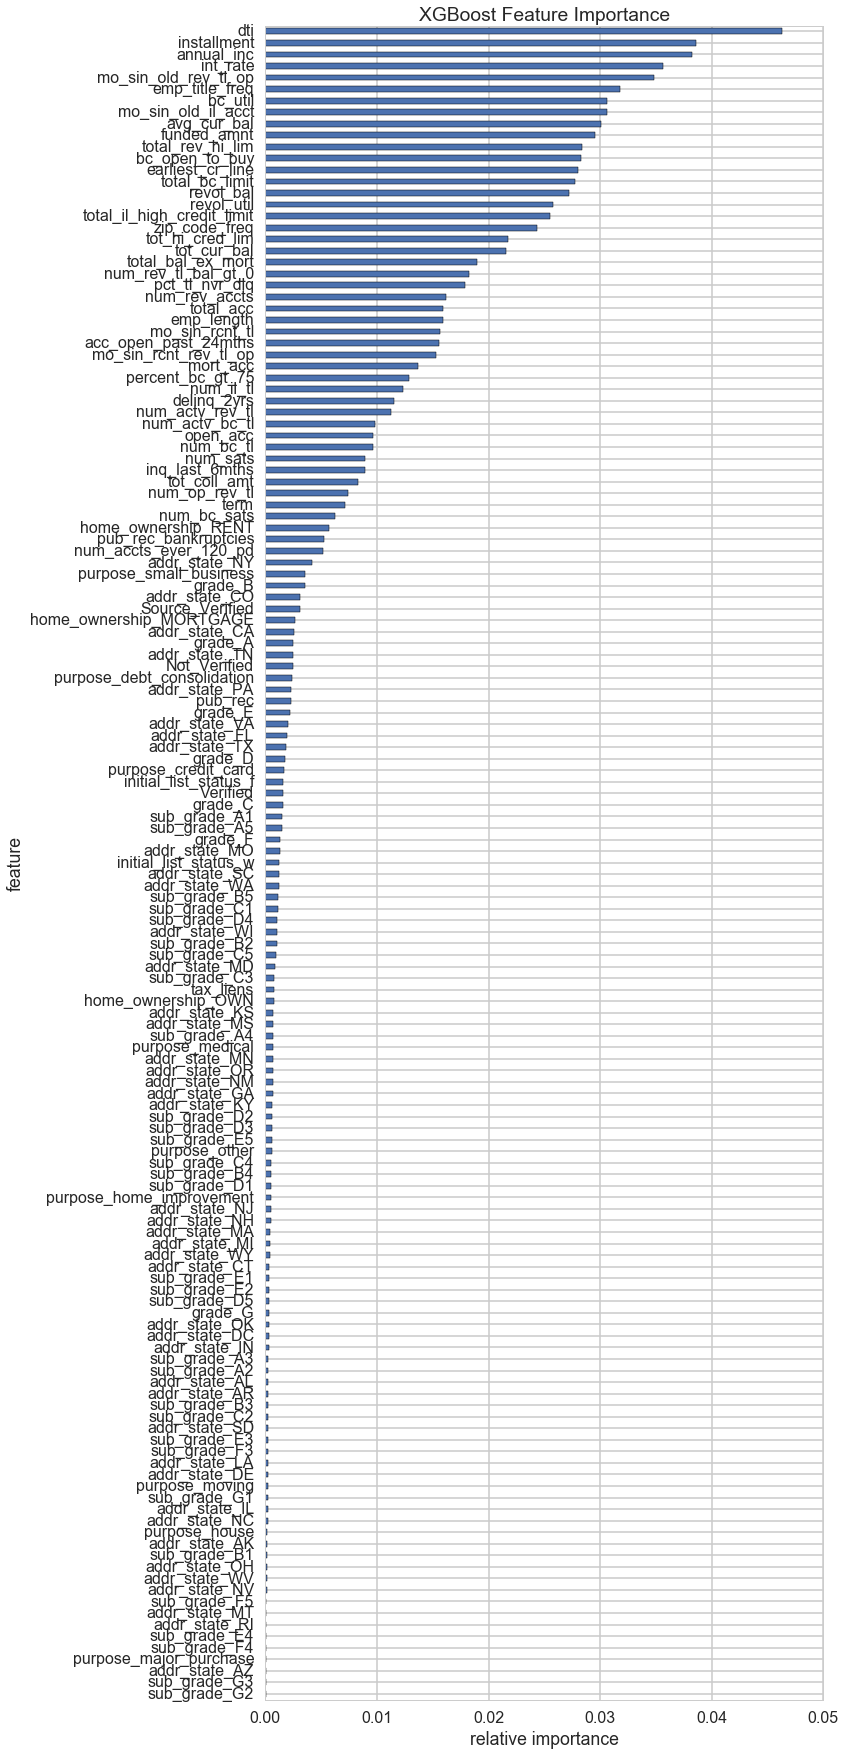

In [81]:
df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()
df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(10, 30))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')

In [82]:
df.sort_values(by = "fscore",ascending=False).head(20)

,feature,fscore
144,dti,0.046278
143,installment,0.038553
142,annual_inc,0.038264
141,int_rate,0.035593
140,mo_sin_old_rev_tl_op,0.034799
139,emp_title_freq,0.031767
138,bc_util,0.030612
137,mo_sin_old_il_acct,0.030612
136,avg_cur_bal,0.030034
135,funded_amnt,0.029529


# GIS

In [89]:
df_gis =df_all[df_all['train_flg']==0][['addr_state']]

In [93]:
df_gis['predict'] = y_pred

In [94]:
df_gis.head()

,addr_state,predict
77792,VA,0.155345
77793,MO,0.308621
77794,AZ,0.274142
77795,NJ,0.259586
77796,MN,0.076022


In [96]:
df_gis = df_gis.groupby('addr_state').mean().reset_index()

In [106]:
df_gis['color_factor'] = (df_gis['predict']-df_gis['predict'].min())/(df_gis['predict'].max()-df_gis['predict'].min())

In [112]:
print df_gis.shape[0]
df_gis.head(10)

46


,addr_state,predict,color_factor
0,AK,0.257870,0.798683
1,AL,0.247837,0.690137
2,AR,0.270301,0.933179
3,AZ,0.221296,0.402979
4,CA,0.215695,0.342370
5,CO,0.186799,0.029735
6,CT,0.202011,0.194320
7,DC,0.184051,0.000000
8,DE,0.239141,0.596043
9,FL,0.245721,0.667236


In [100]:
from mpl_toolkits.basemap import Basemap

from matplotlib.patches import Polygon, PathPatch
from matplotlib.collections import PatchCollection


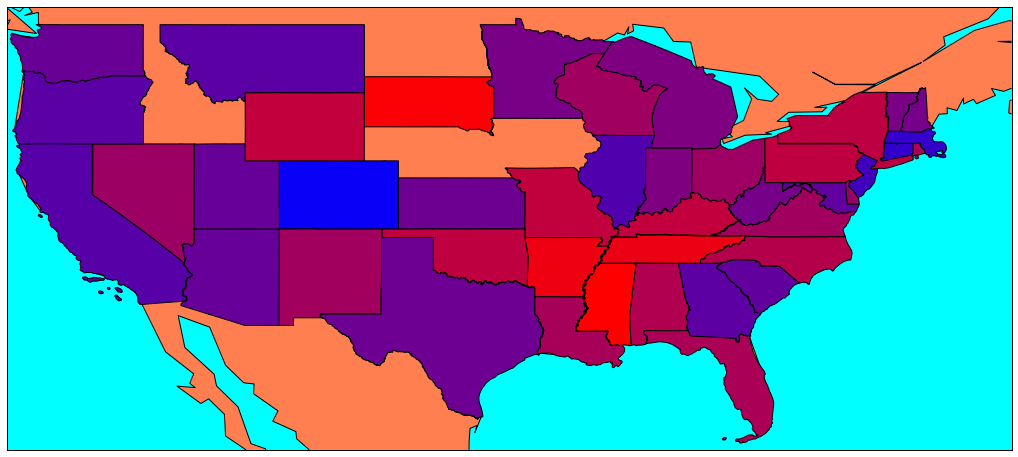

In [125]:
fig, ax = plt.subplots(1,1,figsize=(18,15))
map = Basemap(llcrnrlon = -125 , llcrnrlat =24, urcrnrlon =-66, urcrnrlat =50, projection ='cyl')
map.drawmapboundary(fill_color = 'aqua')
map.fillcontinents(color = 'coral', lake_color = 'aqua')
map.drawcoastlines()
map.readshapefile('tl_2016_us_state/tl_2016_us_state','comarques',drawbounds = False)


for row in df_gis.iterrows():
    state = row[1]['addr_state']
    color_factor = row[1]['color_factor']
    
    patches =[]
    for info, shape in zip(map.comarques_info,map.comarques):
        if info['STUSPS'] == state:
            patches.append(Polygon(np.array(shape),True))

    ax.add_collection(PatchCollection(patches,facecolor = (color_factor, 0.0, 1.0-color_factor),edgecolor ='k',linewidths =1., zorder =2))



plt.show()

## more red means bad loan probability is higher,
## more blue means bad loan probability is lower.